# Table of contents
1. [Load Data](#loaddata)  
2. [Data Pre-processing](#datapreprocessing)
3. [Preliminary EDA](#eda1)
4. [Categorical Encoding](#catenc)
5. [EDA on Basic Features](#eda2)
6. [Feature Engineering](#fe)
7. [Undersampling](#undersampling)
8. [EDA on Newly Created Features](#eda3)
9. [Load Undersampled Train](#train)
10. [Feature Selection](#featureselection)
11. [Preparing Testing Set](#preptest)
12. [Model Building](#modelbuilding)  
  12.1 [Logistic Regression](#lr)  
  12.2 [K Nearest Neighbours (KNN)](#knn)  
  12.3 [Neural Network](#nn)  
  12.4 [Random Forest](#rf)  
  12.5 [XGBoost](#xg)      
  12.6 [Ensemble Classifier](#ensemble)  
13. [Model Evaluation](#modeleval)

In [1]:
# For data processing and plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# For train-test split
from sklearn.model_selection import train_test_split

# For loading dataset which exceeds memory
import dask.dataframe as dd

# For categorical encoding
import category_encoders as ce

# For normalization
from sklearn.preprocessing import MinMaxScaler

# For combination
from itertools import combinations

# For evaluation metrics
from sklearn import metrics

# For logistic regression
from sklearn.linear_model import LogisticRegression

# For KNN
from sklearn.neighbors import KNeighborsClassifier

# For XGBoost
from xgboost import XGBClassifier, plot_importance

# For random forest classifier
from sklearn.ensemble import RandomForestClassifier

# For ensemble classifier
from sklearn.ensemble import VotingClassifier

# For neural network
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score

# For hyperparameters tuning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization # Bayesian optimization is more efficient in time and memory capacity for tuning many hyperparameters

In [3]:
# To ignore warning
import warnings
warnings.filterwarnings("ignore")

## Load Data <a name="loaddata"></a>

In [3]:
data = dd.read_csv('./data.csv', dtype={'attributed_time': 'object'})

#### Summary of Variables

| Variable Name   | Definition                                                                | Type        |
|-----------------|---------------------------------------------------------------------------|-------------|
| ip              | IP address of click                                                       | Categorical |
| app             | App id for marketing                                                      | Categorical |
| device          | Device type id of mobile phone                                            | Categorical |
| os              | OS version id of mobile phone                                             | Categorical |
| channel         | Channel id of ad publisher                                                | Categorical |
| click_time      | Timestamp of click (UTC)                                                  | Numerical   |
| attributed_time | If user downloads app after clicking ad, this is the time of app download | Numerical   |
| is_attributed   | Target to be predicted, 1 if app was downloaded                           | Categorical |

As attributed_time is only available when the app was downloaded (is_attributed = 1), this variable will not provide much useful information about whether certain users will download the app or not. Therefore, we decided to **drop attributed_time** to free up more memory.

In [9]:
print(f"Number of observations: {data.shape[0].compute()}")

Number of observations: 184903890


Besides, we observe that this dataset is huge with more than 184 million observations, which cannot be handled by our machines. Hence we decided to **randomly take approximately 25% of the observations as samples** from the original dataset to reduce its size. We believe that after random sampling, the data size is still big enough for us to do analysis.

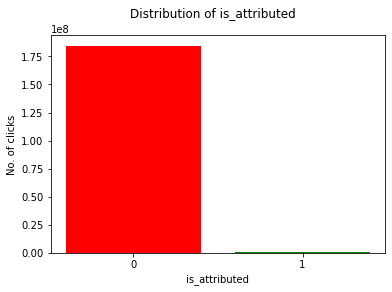

In [16]:
# Obtain counts of each class
data_0, data_1 = data["is_attributed"].value_counts()

# Plot distribution of is_attributed
fig, ax = plt.subplots()
fig.suptitle('Distribution of is_attributed')
labels = ['0', '1']
counts= [data_0, data_1]
ax.set_ylabel('No. of clicks')
ax.set_xlabel("is_attributed")
bars = ax.bar(labels, counts, color = ('red','green'))
plt.show()

From the plot above, we also observe that the dataset is highly imbalanced. Therefore, in the later part of the project, we will perform **undersampling on the training set**.

## Data Pre-processing <a name="datapreprocessing"></a>

### Random Sampling (without replacement)

In [2]:
<a name="introduction"></a># Read data by chunks of 10 million observations
# Sample 2.5 million observations randomly without replacement

data = pd.DataFrame()

chunksize = 10**7
with pd.read_csv('./data.csv', chunksize=chunksize) as reader:
  for chunk in reader:
    chunk = chunk.sample(n = int(chunksize/4), replace = False, random_state = 0)
    data = pd.concat([data, chunk])
    print(data.shape)

(2500000, 8)
(5000000, 8)
(7500000, 8)
(10000000, 8)
(12500000, 8)
(15000000, 8)
(17500000, 8)
(20000000, 8)
(22500000, 8)
(25000000, 8)
(27500000, 8)
(30000000, 8)
(32500000, 8)
(35000000, 8)
(37500000, 8)
(40000000, 8)
(42500000, 8)
(45000000, 8)
(47500000, 8)


In [28]:
print(data.shape)
print(data["is_attributed"].value_counts())

(47500000, 8)
0    47383465
1      116535
Name: is_attributed, dtype: int64


### Remove Duplicates

In [3]:
print('Check whether there are duplicates:', data.duplicated().any())
print('Number of duplicates:', sum(data.duplicated(subset=list(data.columns))))

Check whether there are duplicates: True
Number of duplicates: 249747


In [4]:
data = data.drop_duplicates()

print(data.shape)
print(data["is_attributed"].value_counts())

(47250253, 8)
0    47133719
1      116534
Name: is_attributed, dtype: int64


### Check for Missing Values

In [3]:
data.isna().sum()

ip                        0
app                       0
device                    0
os                        0
channel                   0
click_time                0
attributed_time    47383465
is_attributed             0
dtype: int64

### Drop attributed_time

In [5]:
data = data.drop('attributed_time', axis=1)
data.head()

,ip,app,device,os,channel,click_time,is_attributed
9487273,159670,2,1,19,435,2017-11-07 00:03:10,0
1409143,81834,6,1,3,125,2017-11-06 16:32:41,0
4861323,2896,12,1,17,245,2017-11-06 20:07:33,0
1226788,140931,64,1,15,459,2017-11-06 16:27:49,0
5698172,121966,1,1,1,134,2017-11-06 21:57:34,0


In [6]:
data.to_csv('./data_sampled.csv', index=False)

### Train-test split

In [7]:
X = data.iloc[:,:-1]
y = data["is_attributed"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print(X_train.shape, X_test.shape)
print(X_train.columns)

(37800202, 6) (9450051, 6)
Index(['ip', 'app', 'device', 'os', 'channel', 'click_time'], dtype='object')


In [9]:
# Save sampled train and test datasets
y_train = pd.DataFrame({'is_attributed': y_train}) 
y_test = pd.DataFrame({'is_attributed': y_test})
train_sampled = pd.concat([X_train, y_train],  axis=1)
test_sampled = pd.concat([X_test, y_test],  axis=1)
train_sampled.to_csv('./train_sampled.csv', index=False)
test_sampled.to_csv('./test_sampled.csv', index=False)

## Preliminary EDA <a name="eda1"></a>

To have a better understanding of the dataset, we performed exploratory data analysis on the training set.

In [13]:
unique_values = []

for x in train_sampled.iloc[:,:-1].columns:
  unique_values.append(len(train_sampled[x].unique()))

print(len(unique_values))
print(unique_values)

6
[207266, 525, 2124, 493, 187, 259316]


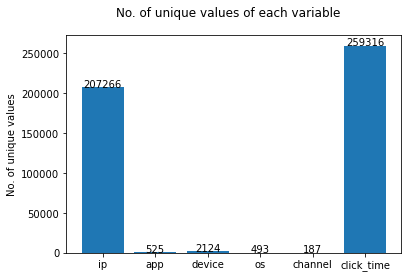

In [16]:
# Count of unique values of variables
fig, ax = plt.subplots()
fig.suptitle('No. of unique values of each variable')
labels = train_sampled.iloc[:,:-1].columns.tolist()

ax.set_ylabel('No. of unique values')
ax.bar(labels, unique_values)

for index, value in enumerate(unique_values):
    ax.text(x = index, y = value, s=str(value), fontdict=dict(fontsize=10), ha="center")

Categorical variables (ip, app, device, os, and channel) are encoded as numbers, i.e. each unique category is represented by a unique number. To avoid introducing irrelavant numerical relationship, we need to re-encode these catorical variables. 

However, we observe that all categorical variables have high cardinalities (more than 100 categories). As such, one-hot encoding may not be a feasible choice as it will make the feature space of the encoded dataset to be very huge. Therefore, to avoid this problem, we decided to do **count encoding**, where each category in each categorical variable will be replaced by the count of that category. If the test set has a unknown never seen before categories, it will be replaced by 0.

## Categorical Encoding <a name="catenc"></a>

In [18]:
categorical_features = ['ip', 'app', 'device', 'os', 'channel']

# Normalize the counts here as the count seems too big which may affect gradient descent
count_enc = ce.CountEncoder(cols=categorical_features, handle_unknown='value', normalize=True)
new_train_categories = count_enc.fit_transform(train_sampled[categorical_features])
new_train_categories.columns = ['ip_enc', 'app_enc', 'device_enc', 'os_enc', 'channel_enc']

train_enc = pd.concat([train_sampled, new_train_categories], axis = 1)
train_enc.head()

,ip,app,device,os,channel,click_time,is_attributed,ip_enc,app_enc,device_enc,os_enc,channel_enc
0,304834,20,1,17,259,2017-11-09 15:58:50,0,0.000003,0.009599,0.942435,0.052055,0.030631
1,55874,3,1,13,371,2017-11-09 09:24:01,0,0.000069,0.181819,0.942435,0.214987,0.003278
2,55988,12,1,22,259,2017-11-06 16:25:11,0,0.000046,0.130055,0.942435,0.040222,0.030631
3,204669,15,1,13,245,2017-11-07 00:54:21,0,0.000017,0.085924,0.942435,0.214987,0.047045
4,68632,14,1,19,401,2017-11-07 03:13:22,0,0.000009,0.054620,0.942435,0.238728,0.007474


In [73]:
train_enc.to_csv('./train_enc.csv', index=False)

## EDA on Basic Features <a name="eda2"></a>

After encoding the categorical variables, we are able to do more exploratory data analysis to visualize the difference between normal (is_attributed=1) and fraud (is_attributed=0) classes.

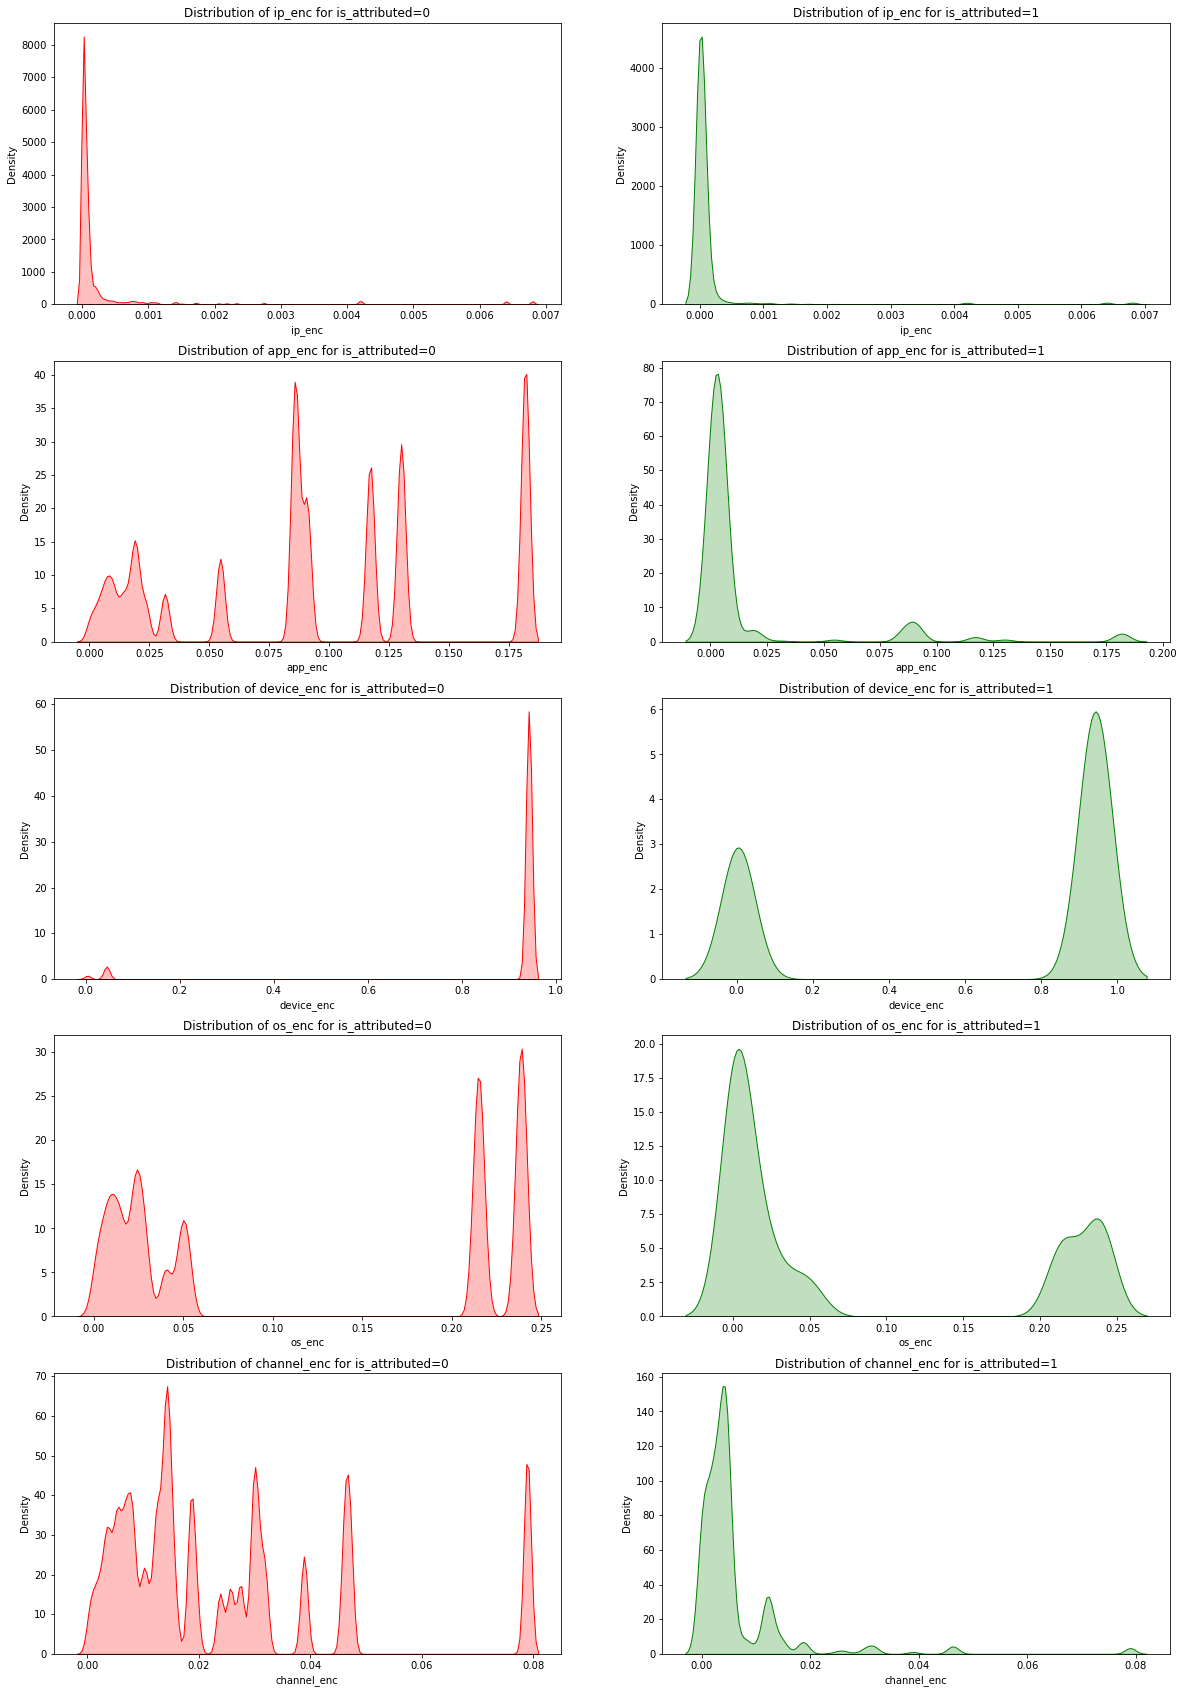

In [23]:
plt.figure(figsize=(20, 30))
for index, var in enumerate(train_enc.columns[7:]):
    plt.subplot(5, 2, index*2+1)
    sns.kdeplot(data=train_enc[train_enc["is_attributed"] == 0], x=var, fill=True, color='red')
    plt.title(f"Distribution of {var} for is_attributed=0")
    plt.subplot(5, 2, index*2+2)
    sns.kdeplot(data=train_enc[train_enc["is_attributed"] == 1], x=var, fill=True, color='green')
    plt.title(f"Distribution of {var} for is_attributed=1")

From the plots above, there is no significant difference in the distribution for ip between normal class and fraud class. Hence, it is not a good feature.

However, there are significant difference in the distribution for app, device, os and channel between normal class and fraud class. Hence, these features are potential candidates for modelling. 

## Feature Engineering <a name="fe"></a>

As we only have 4 candidate features from the dataset, we will be creating new features from the existing features. To decide whether these features will be used for modelling, we will evaluate based on EDA and feature importance in the later part of the project.

In [27]:
train=train_sampled.copy()

In [125]:
train.head(5)

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,uniq_os_per_device_trans,uniq_channel_per_device_trans,uniq_ip_per_os_trans,uniq_app_per_os_trans,uniq_device_per_os_trans,uniq_channel_per_os_trans,uniq_ip_per_channel_trans,uniq_app_per_channel_trans,uniq_device_per_channel_trans,uniq_os_per_channel_trans
0,304834,20,1,17,259,2017-11-09 15:58:50,0,9,15,58,...,1.0,1.0,0.656630,0.587361,0.003413,0.988024,0.781105,0.018182,0.003131,0.915556
1,55874,3,1,13,371,2017-11-09 09:24:01,0,9,9,24,...,1.0,1.0,0.946606,0.765799,0.003413,0.994012,0.331738,0.013636,0.002505,0.488889
2,55988,12,1,22,259,2017-11-06 16:25:11,0,6,16,25,...,1.0,1.0,0.619204,0.550186,0.003413,0.934132,0.781105,0.018182,0.003131,0.915556
3,204669,15,1,13,245,2017-11-07 00:54:21,0,7,0,54,...,1.0,1.0,0.946606,0.765799,0.003413,0.994012,0.799959,0.004545,0.003131,0.551111
4,68632,14,1,19,401,2017-11-07 03:13:22,0,7,3,13,...,1.0,1.0,1.000000,0.743494,0.003413,1.000000,0.560904,0.004545,0.000626,0.524444


### Extract time features from click_time

In [16]:
# Create day, hour, minute, second features
train_datetime = pd.to_datetime(train['click_time'], format='%Y-%m-%d %H:%M:%S')
train['click_time'] = train_datetime
train['day'] = train_datetime.dt.day
train['hour'] = train_datetime.dt.hour
train['minute'] = train_datetime.dt.minute
train['second'] = train_datetime.dt.second

### Unique count features

Features with the name *uniq_agg_var_per_by_var* represent the number of unique values of agg_var in certain by_var groups.

In [54]:
# Unique counts
def agg_unique(df, group_cols, unique_col, name):
  grp = df[group_cols+[unique_col]].groupby(group_cols)[unique_col].nunique().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df

In [55]:
# Group by single feature
for by_var in ['ip', 'app', 'device', 'os', 'channel', 'hour']:
    for agg_var in ['ip', 'app', 'device', 'os', 'channel', 'hour']:
        if by_var != agg_var:
            print(f">> Creating uniq_{agg_var}_per_{by_var}")
            train = agg_unique(train, [by_var], agg_var, f"uniq_{agg_var}_per_{by_var}")

>> Creating uniq_app_per_ip
>> Creating uniq_device_per_ip
>> Creating uniq_os_per_ip
>> Creating uniq_channel_per_ip
>> Creating uniq_hour_per_ip
>> Creating uniq_ip_per_app
>> Creating uniq_device_per_app
>> Creating uniq_os_per_app
>> Creating uniq_channel_per_app
>> Creating uniq_hour_per_app
>> Creating uniq_ip_per_device
>> Creating uniq_app_per_device
>> Creating uniq_os_per_device
>> Creating uniq_channel_per_device
>> Creating uniq_hour_per_device
>> Creating uniq_ip_per_os
>> Creating uniq_app_per_os
>> Creating uniq_device_per_os
>> Creating uniq_channel_per_os
>> Creating uniq_hour_per_os
>> Creating uniq_ip_per_channel
>> Creating uniq_app_per_channel
>> Creating uniq_device_per_channel
>> Creating uniq_os_per_channel
>> Creating uniq_hour_per_channel
>> Creating uniq_ip_per_hour
>> Creating uniq_app_per_hour
>> Creating uniq_device_per_hour
>> Creating uniq_os_per_hour
>> Creating uniq_channel_per_hour


In [56]:
# Min max transformation
for var in train[train.columns[11:]]:
    scaler = MinMaxScaler()
    df = pd.DataFrame(data={var: train[var]})
    trans = scaler.fit_transform(df).reshape(1,-1)[0]
    train[f'{var}_trans'] = trans

In [138]:
# Group by multiple features
for by_var in [['ip','day'], ['ip','app'], ['ip', 'device', 'os']]:
    for agg_var in ['ip', 'app', 'device', 'os', 'channel', 'hour']:
        if not (agg_var in by_var):
            print(f">> Creating uniq_{agg_var}_per_{'_'.join(by_var)}")
            train = agg_unique(train, by_var, agg_var, f"uniq_{agg_var}_per_{'_'.join(by_var)}")

>> Creating uniq_app_per_ip_day
>> Creating uniq_device_per_ip_day
>> Creating uniq_os_per_ip_day
>> Creating uniq_channel_per_ip_day
>> Creating uniq_hour_per_ip_day
>> Creating uniq_device_per_ip_app
>> Creating uniq_os_per_ip_app
>> Creating uniq_channel_per_ip_app
>> Creating uniq_hour_per_ip_app
>> Creating uniq_app_per_ip_device_os
>> Creating uniq_channel_per_ip_device_os
>> Creating uniq_hour_per_ip_device_os


In [140]:
# Min max transformation
for var in train[train.columns[71:]]:
    scaler = MinMaxScaler()
    df = pd.DataFrame(data={var: train[var]})
    trans = scaler.fit_transform(df).reshape(1,-1)[0]
    train[f'{var}_trans'] = trans

### Cumulative count features

Features with the name *cum_count_by_var* represent the number of observations appearing before the current observation in certain var groups.

In [5]:
# Cumulative counts
def agg_cum_count(df, group_cols, name):
  grp = df[group_cols].groupby(group_cols).cumcount()
  df[name] = grp.values
  return df

In [6]:
combi = []
for i in range(1, 6):
    combi += list(combinations(['app', 'device', 'os', 'channel', 'hour'], i))

In [9]:
for var in combi:
    print(f">> Creating cum_count_by_{'_'.join(var)}")
    train = agg_cum_count(train, list(var), f"cum_count_by_{'_'.join(var)}")

>> Creating cum_count_by_app
>> Creating cum_count_by_device
>> Creating cum_count_by_os
>> Creating cum_count_by_channel
>> Creating cum_count_by_hour
>> Creating cum_count_by_app_device
>> Creating cum_count_by_app_os
>> Creating cum_count_by_app_channel
>> Creating cum_count_by_app_hour
>> Creating cum_count_by_device_os
>> Creating cum_count_by_device_channel
>> Creating cum_count_by_device_hour
>> Creating cum_count_by_os_channel
>> Creating cum_count_by_os_hour
>> Creating cum_count_by_channel_hour
>> Creating cum_count_by_app_device_os
>> Creating cum_count_by_app_device_channel
>> Creating cum_count_by_app_device_hour
>> Creating cum_count_by_app_os_channel
>> Creating cum_count_by_app_os_hour
>> Creating cum_count_by_app_channel_hour
>> Creating cum_count_by_device_os_channel
>> Creating cum_count_by_device_os_hour
>> Creating cum_count_by_device_channel_hour
>> Creating cum_count_by_os_channel_hour
>> Creating cum_count_by_app_device_os_channel
>> Creating cum_count_by_app_de

In [13]:
# Min max transformation
for var in train.columns[95:]:
    scaler = MinMaxScaler()
    df = pd.DataFrame(data={var: train[var]})
    trans = scaler.fit_transform(df).reshape(1,-1)[0]
    train[f'{var}_trans'] = trans

### Total count features

Features with the name *var_counts* represent the total number of observations in certain var groups.

In [219]:
# Total counts
def agg_counts(df, group_cols, name):
  grp = df[group_cols].groupby(group_cols).size().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df

In [262]:
combi = []
for i in range(2, 6):
    combi += list(combinations(['app', 'device', 'os', 'channel', 'hour'], i))

In [266]:
for var in combi:
    print(f">> Creating {'_'.join(var)}_counts")
    train = agg_counts(train, list(var), f"{'_'.join(var)}_counts")

>> Creating app_device_counts
>> Creating app_os_counts
>> Creating app_channel_counts
>> Creating app_hour_counts
>> Creating device_os_counts
>> Creating device_channel_counts
>> Creating device_hour_counts
>> Creating os_channel_counts
>> Creating os_hour_counts
>> Creating channel_hour_counts
>> Creating app_device_os_counts
>> Creating app_device_channel_counts
>> Creating app_device_hour_counts
>> Creating app_os_channel_counts
>> Creating app_os_hour_counts
>> Creating app_channel_hour_counts
>> Creating device_os_channel_counts
>> Creating device_os_hour_counts
>> Creating device_channel_hour_counts
>> Creating os_channel_hour_counts
>> Creating app_device_os_channel_counts
>> Creating app_device_os_hour_counts
>> Creating app_device_channel_hour_counts
>> Creating app_os_channel_hour_counts
>> Creating device_os_channel_hour_counts
>> Creating app_device_os_channel_hour_counts


In [269]:
# Min max transformation
for var in train.columns[157:]:
    scaler = MinMaxScaler()
    df = pd.DataFrame(data={var: train[var]})
    trans = scaler.fit_transform(df).reshape(1,-1)[0]
    train[f'{var}_trans'] = trans

### Time till next click features

Features with name *var_nextClick* represents the difference between click_time of the current observation and the next one in vertain var groups.

In [17]:
def time_till_next(df, group_cols, name):
    df_sub = df[group_cols+['click_time']]
    df[name] = df_sub.groupby(group_cols).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    df[name].fillna(0, inplace=True)
    return df

In [18]:
combi = []
for i in range(1, 6):
    combi += list(combinations(['ip', 'app', 'device', 'os', 'channel'], i))

In [ ]:
for var in combi:
    print(f">> Creating {'_'.join(var)}_nextClick")
    train = time_till_next(train, list(var), f"{'_'.join(var)}_nextClick")

>> Creating ip_nextClick
>> Creating app_nextClick
>> Creating device_nextClick
>> Creating os_nextClick
>> Creating channel_nextClick
>> Creating ip_app_nextClick
>> Creating ip_device_nextClick
>> Creating ip_os_nextClick
>> Creating ip_channel_nextClick
>> Creating app_device_nextClick
>> Creating app_os_nextClick
>> Creating app_channel_nextClick
>> Creating device_os_nextClick
>> Creating device_channel_nextClick
>> Creating os_channel_nextClick
>> Creating ip_app_device_nextClick
>> Creating ip_app_os_nextClick
>> Creating ip_app_channel_nextClick
>> Creating ip_device_os_nextClick
>> Creating ip_device_channel_nextClick
>> Creating ip_os_channel_nextClick
>> Creating app_device_os_nextClick
>> Creating app_device_channel_nextClick
>> Creating app_os_channel_nextClick
>> Creating device_os_channel_nextClick
>> Creating ip_app_device_os_nextClick
>> Creating ip_app_device_channel_nextClick
>> Creating ip_app_os_channel_nextClick


In [377]:
# Min max transformation
for var in train.columns[209:]:
    scaler = MinMaxScaler()
    df = pd.DataFrame(data={var: train[var]})
    trans = scaler.fit_transform(df).reshape(1,-1)[0]
    train[f'{var}_trans'] = trans

### Combine with encoded categorical variables

In [ ]:
for var in train_enc.columns:
    if "enc" in var:
        train[var] = train_enc[var]

In [419]:
train.to_csv('./train.csv', index=False)

### Extract Min and Max values for newly created features

Since normalization is performed on those newly created features, we need to extract the min and max values of each features in preperation for processing testing set in the later part of the project.

In [92]:
features = ['uniq_app_per_ip_day', 'uniq_os_per_ip_day', 'uniq_channel_per_ip_day',
 'uniq_hour_per_ip_day', 'uniq_os_per_ip_app', 'uniq_channel_per_ip_app',
 'uniq_hour_per_ip_app', 'uniq_app_per_ip_device_os', 'uniq_channel_per_ip_device_os',
 'uniq_hour_per_ip_device_os', 'uniq_app_per_ip', 'uniq_os_per_ip', 'uniq_channel_per_ip',
 'uniq_hour_per_ip', 'uniq_ip_per_app', 'uniq_device_per_app', 'uniq_os_per_app', 'uniq_channel_per_app',
 'uniq_ip_per_device', 'uniq_app_per_device', 'uniq_os_per_device', 'uniq_channel_per_device',
 'uniq_ip_per_os', 'uniq_app_per_os', 'uniq_device_per_os', 'uniq_channel_per_os',
 'uniq_ip_per_channel', 'uniq_app_per_channel', 'uniq_device_per_channel', 'uniq_os_per_channel',
 'ip_nextClick', 'ip_app_nextClick', 'ip_device_nextClick', 'ip_os_nextClick', 'ip_channel_nextClick',
 'ip_app_device_nextClick', 'app_device_counts', 'app_channel_counts', 'app_hour_counts',
 'device_channel_counts', 'device_hour_counts', 'channel_hour_counts',
 'cum_count_by_app', 'cum_count_by_device', 'cum_count_by_channel']
max_values=[]
min_values=[]
for var in features:
    X=train[var]
    max_values.append(X.max(axis=0))
    min_values.append(X.min(axis=0))

In [95]:
df=pd.DataFrame()
df['Features'] = features
df['Max'] = max_values
df['Min'] = min_values

In [101]:
df.to_csv('./minmax_values.csv', index=False)

## Undersampling <a name="undersampling"></a>

In [36]:
# Function to do undersampling
def undersample(train):
  train_0 = train[train["is_attributed"] == 0]
  train_1 = train[train["is_attributed"] == 1]

  train_0_count, train_1_count = train["is_attributed"].value_counts()

  # Under-sample class 0
  train_0_under = train_0.sample(n = train_1_count, random_state = 0)

  # Merge undersampled class 0 and original class 1
  train_under = pd.concat([train_0_under, train_1], axis = 0)
  return train_under

In [444]:
train_undersampled = undersample(train)

train_undersampled.shape

(186454, 56)

In [445]:
train_undersampled.to_csv('./train_undersampled_all.csv', index=False)

## EDA on Newly Created Features <a name="eda3"></a>

After doing feature engineering and undersampling, we can do further EDA in preparation for feature selection.

### Time features from click_time

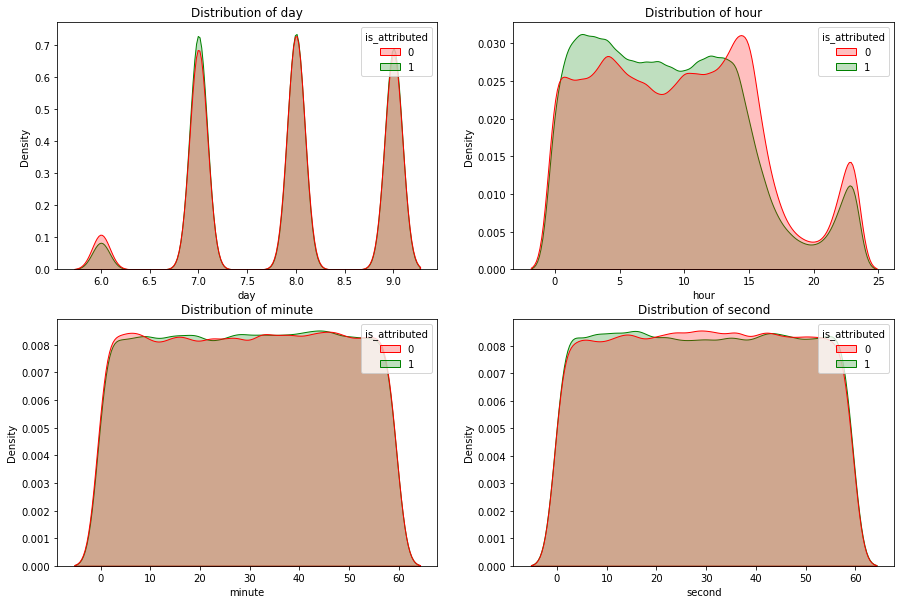

In [215]:
plt.figure(figsize=(15, 10))
for index, var in enumerate(['day', 'hour', 'minute', 'second']):
    plt.subplot(2, 2, index+1)
    sns.kdeplot(data=train_undersampled, x=var, hue="is_attributed", fill=True, palette=('red','green'))
    plt.title(f"Distribution of {var}")
    
plt.show()

From the plots above, these four time-related features alone may not be good features to use as there is not much difference in their distribution between normal and fraud classes. Hence, we will combine them with other features to create new features.

### Unique count features - grouped by single variable

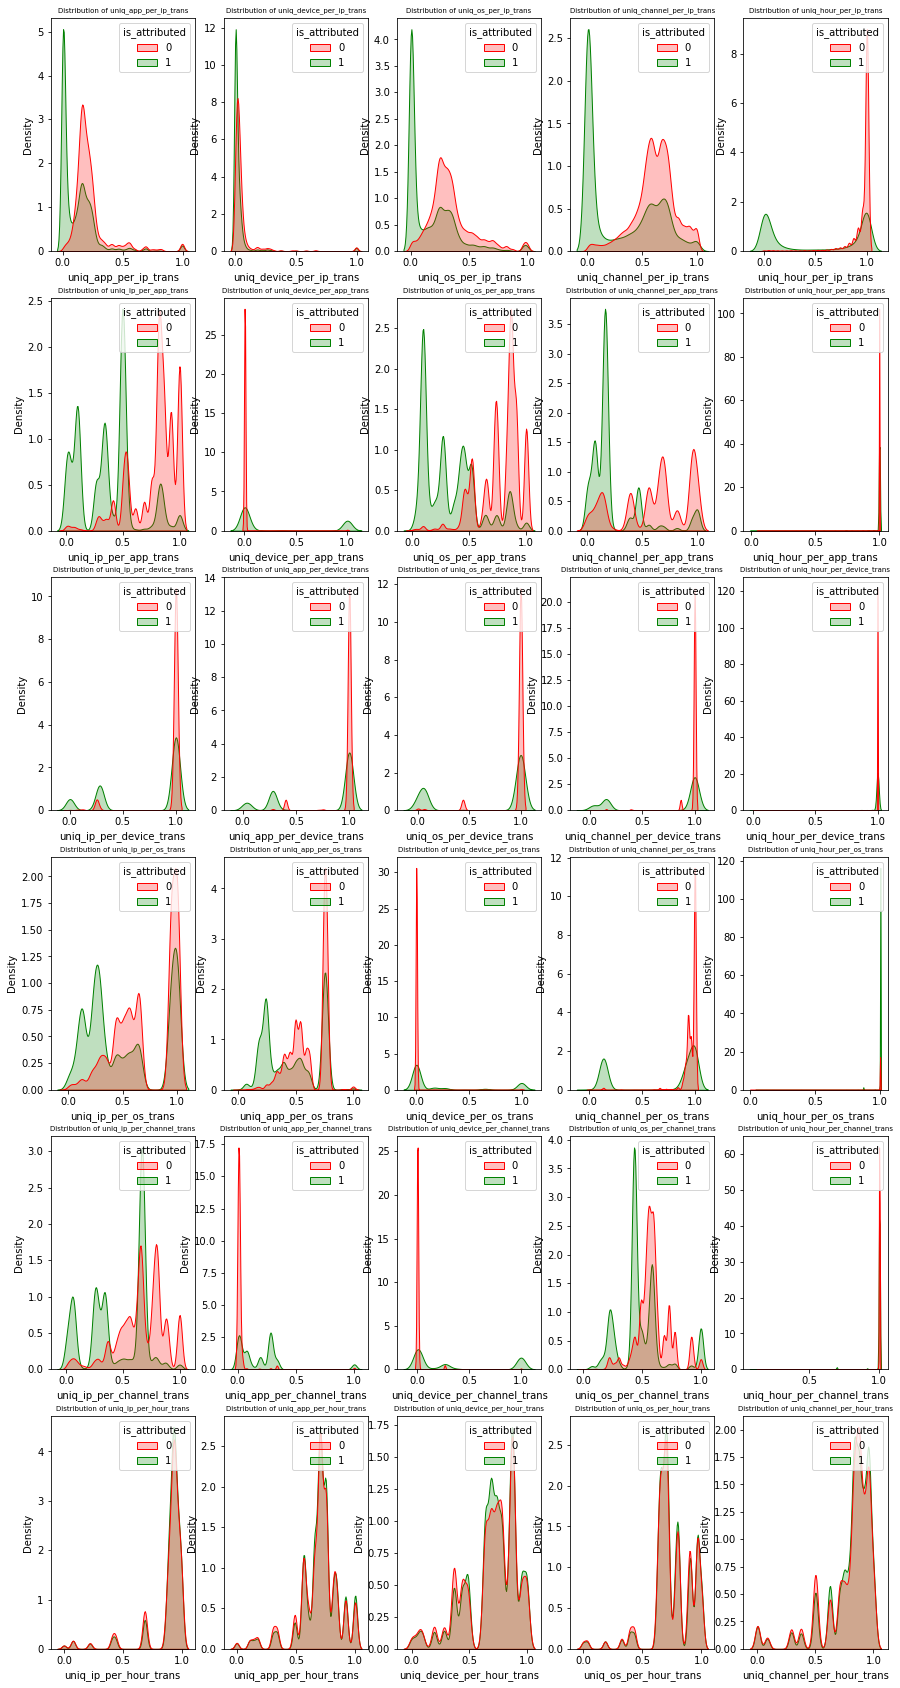

In [84]:
plt.figure(figsize=(15, 30))
for i in range(6):
    for j in range(5):
        plt.subplot(6, 5, i*5+j+1)
        sns.kdeplot(data=train_undersampled, x=train_undersampled.columns[41+i*5+j], 
                    hue="is_attributed", fill=True, palette=('red','green'))
        plt.title(f"Distribution of {train_undersampled.columns[37+i*5+j]}", fontsize = 7)

plt.show()

The following features **may not be good features** as there is no significant difference in their distribution between normal and fraud class: <br/>
'uniq_device_per_ip', <br/>
'uniq_hour_per_app', <br/>
'uniq_hour_per_device', <br/>
'uniq_hour_per_os', <br/>
'uniq_hour_per_channel', <br/>
'uniq_ip_per_hour', 'uniq_app_per_hour', 'uniq_device_per_hour', 'uniq_os_per_hour', 'uniq_channel_per_hour'


Instead, these featurs **may be good features** because there is a some difference in their distribution between normal and fraud class: <br/>
'uniq_app_per_ip', 'uniq_os_per_ip', 'uniq_channel_per_ip', 'uniq_hour_per_ip', <br/>
'uniq_ip_per_app', 'uniq_device_per_app', 'uniq_os_per_app', 'uniqu_channel_per_app', <br/>
'uniq_ip_per_device', 'uniq_app_per_device', 'uniq_os_per_device', 'uniq_channel_per_device', <br/>
'uniq_ip_per_os', 'uni_app_per_os', 'uniq_device_per_os', 'uniq_channel_per_os', <br/>
'uniq_ip_per_channel, 'uniq_app_per_channel', 'uniq_device_per_channel', 'uniq_os_per_channel'.

### Unique count features - grouped by multiple variables

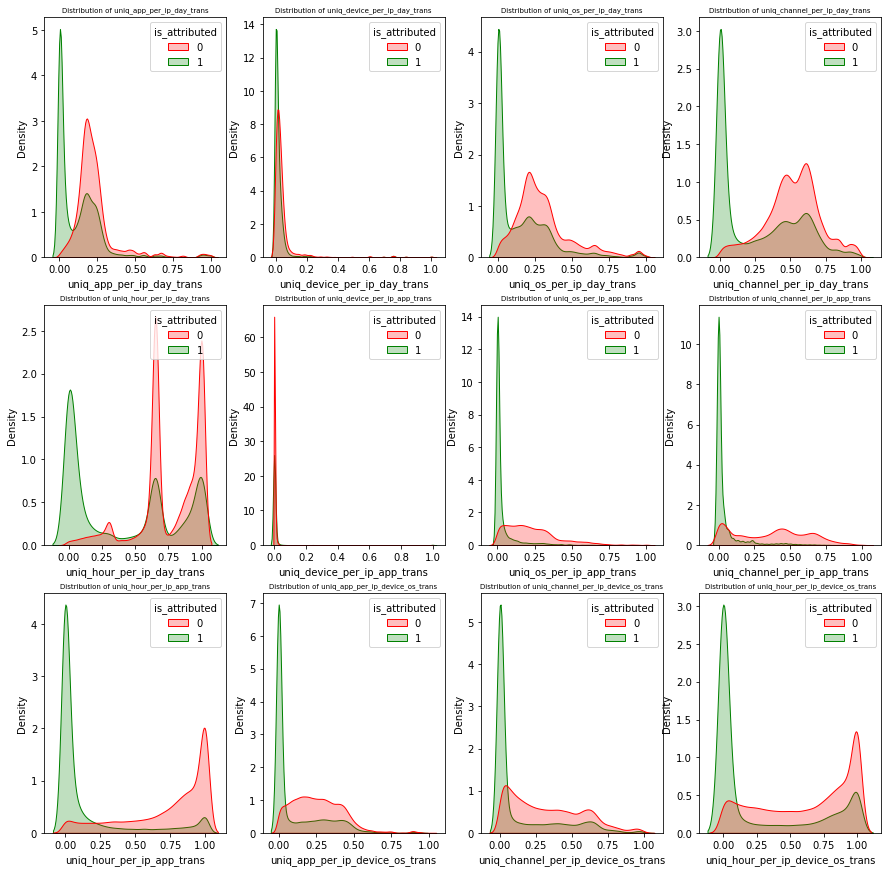

In [146]:
plt.figure(figsize=(15, 15))
for index, var in enumerate(train_undersampled.columns[83:95]):
    plt.subplot(3, 4, index+1)
    sns.kdeplot(data=train_undersampled, x=var, hue="is_attributed", fill=True, palette=('red','green'))
    plt.title(f"Distribution of {var}", fontsize = 7)

plt.show()

The following features **may not be good features** as there is no significant difference in their distribution between normal and fraud class: <br/>
'uniq_device_per_ip_day', <br/>
'uniq_device_per_ip_app'


Instead, these featurs **may be good features** because there is a significant difference in their distribution between normal and fraud class:
‘uniq_app_per_ip_day’, ‘uniq_os_per_ip_day’, ‘uniq_channel_per_ip_day’, ‘uniq_hour_per_ip_day’, <br/>
'uniq_os_per_ip_app’, 'uniq_channel_per_ip_app’, 'uniq_hour_per_ip_app', <br/>
‘uniq_app_per_ip_device_os’, ‘uniq_channel_per_ip_device_os’, ‘uniq_hour_per_ip_device_os’ <br/>

### Cumulative count features

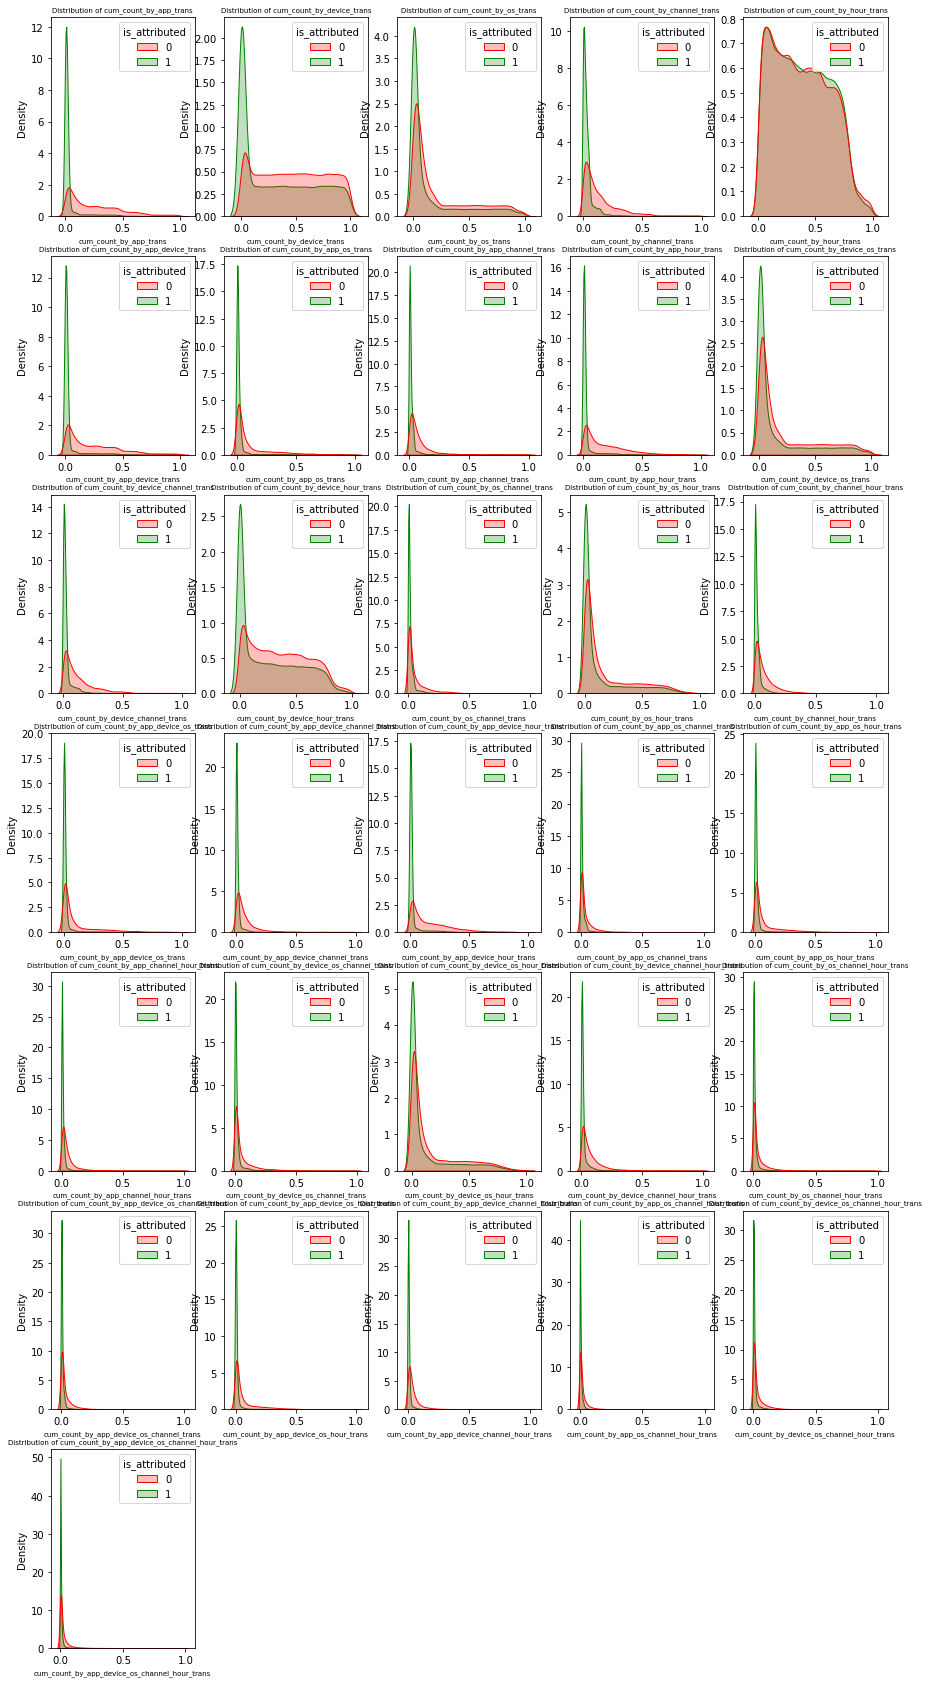

In [293]:
plt.figure(figsize=(15, 30))
for index, var in enumerate(train_undersampled.columns[126:157]):
    plt.subplot(7, 5, index+1)
    sns.kdeplot(data=train_undersampled, x=var, hue="is_attributed", fill=True, palette=('red','green'))
    plt.title(f"Distribution of {var}", fontsize = 7)
    plt.xlabel(var, fontsize = 7)

plt.show()

The following features **may be good features** to use for further analysis: <br/>
'cum_count_by_app', 'cum_count_by_device', 'cum_count_by_channel'

### Total count features

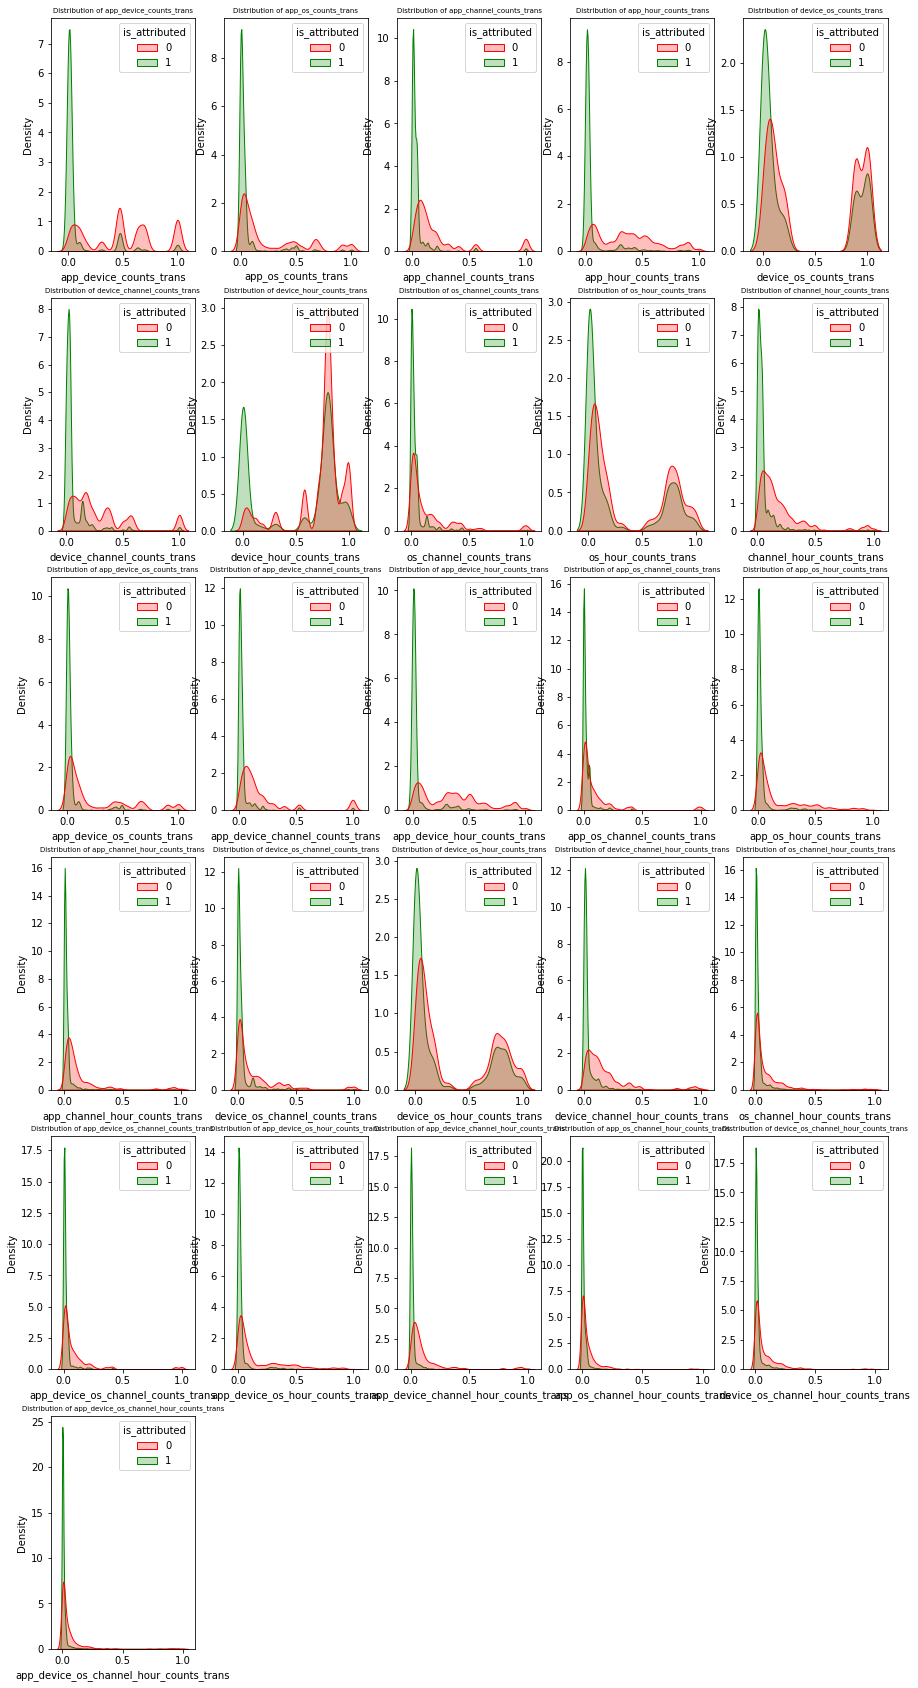

In [273]:
plt.figure(figsize=(15, 30))
for index, var in enumerate(train_undersampled.columns[183:209]):
    plt.subplot(6, 5, index+1)
    sns.kdeplot(data=train_undersampled, x=var, hue="is_attributed", fill=True, palette=('red','green'))
    plt.title(f"Distribution of {var}", fontsize = 7)

plt.show()

The following features **may be good features** to use for further analysis: <br/>
'app_device_counts', 'app_channel_counts', 'app_hour_counts', 'device_channel_counts', 'device_hour_counts', 'channel_hour_counts'

### Time till next click features

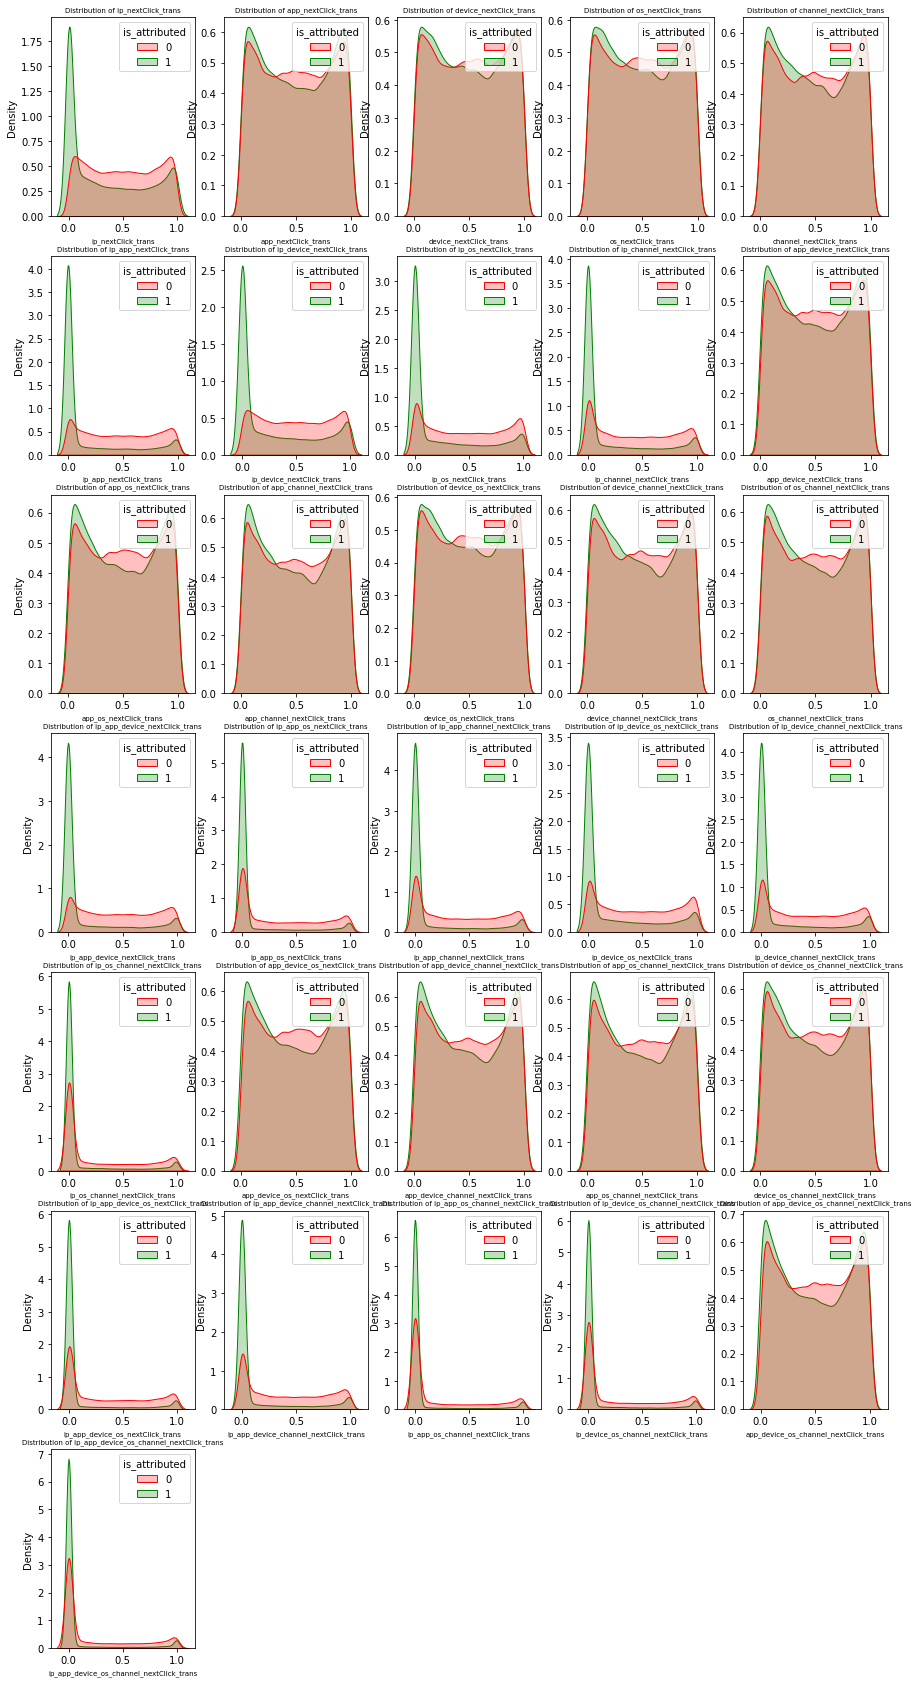

In [387]:
plt.figure(figsize=(15, 30))
for index, var in enumerate(train_undersampled.columns[240:271]):
    plt.subplot(7, 5, index+1)
    sns.kdeplot(data=train_undersampled, x=var, hue="is_attributed", fill=True, palette=('red','green'))
    plt.title(f"Distribution of {var}", fontsize = 7)
    plt.xlabel(var, fontsize = 7)

plt.show()

The following features **may be good features** to use for further analysis: <br/>
'ip_nextClick', <br/>
'ip_app_nextClick', 'ip_device_nextClick', 'ip_os_nextClick', 'ip_channel_nextClick', <br/>
'ip_app_device_nextClick'

### Select features based on EDA

In [ ]:
# Remove non-encoded and non-normalized data
train_new = pd.DataFrame()
for var in train_undersampled.columns:
    if "enc" in var:
        train_new[var[:-4]] = train_undersampled[var]
    if "trans" in var:
        train_new[var[:-6]] = train_undersampled[var]
    if var in ['day', 'hour', 'minute', 'second', 'click_time', 'is_attributed']:
        train_new[var] = train_undersampled[var]

train_undersampled = train_new

In [ ]:
train_undersampled = train_undersampled[['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed',
       'day', 'hour', 'minute', 'second', 'uniq_app_per_ip_day',
       'uniq_os_per_ip_day', 'uniq_channel_per_ip_day', 'uniq_hour_per_ip_day',
       'uniq_os_per_ip_app', 'uniq_channel_per_ip_app', 'uniq_hour_per_ip_app',
       'uniq_app_per_ip_device_os', 'uniq_channel_per_ip_device_os',
       'uniq_hour_per_ip_device_os', 'uniq_app_per_ip', 'uniq_os_per_ip',
       'uniq_channel_per_ip', 'uniq_hour_per_ip', 'uniq_ip_per_app',
       'uniq_device_per_app', 'uniq_os_per_app', 'uniq_channel_per_app',
       'uniq_ip_per_device', 'uniq_app_per_device', 'uniq_os_per_device',
       'uniq_channel_per_device', 'uniq_ip_per_os', 'uniq_app_per_os',
       'uniq_device_per_os', 'uniq_channel_per_os', 'uniq_ip_per_channel',
       'uniq_app_per_channel', 'uniq_device_per_channel',
       'uniq_os_per_channel', 'ip_nextClick', 'ip_app_nextClick',
       'ip_device_nextClick', 'ip_os_nextClick', 'ip_channel_nextClick',
       'ip_app_device_nextClick', 'app_device_counts', 'app_channel_counts',
       'app_hour_counts', 'device_channel_counts', 'device_hour_counts',
       'channel_hour_counts', 'cum_count_by_app', 'cum_count_by_device',
       'cum_count_by_channel']]

In [ ]:
train_undersampled.to_csv('./train_undersampled.csv', index=False)

## Load Undersampled Training Set <a name="train"></a>

In [6]:
train = pd.read_csv('./train_undersampled.csv')
train.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,ip_app_device_nextClick,app_device_counts,app_channel_counts,app_hour_counts,device_channel_counts,device_hour_counts,channel_hour_counts,cum_count_by_app,cum_count_by_device,cum_count_by_channel
0,0.000048,0.085924,0.942435,0.001422,0.047045,2017-11-07 06:18:26,0,7,6,18,...,0.724951,0.470118,0.404262,0.334755,0.586100,0.788327,0.377761,0.442650,0.936941,0.558279
1,0.000056,0.181819,0.942435,0.214987,0.078942,2017-11-07 03:06:29,0,7,3,6,...,0.404854,1.000000,1.000000,0.875513,1.000000,0.812032,0.905031,0.379847,0.379880,0.379802
2,0.000012,0.117137,0.942435,0.238728,0.013642,2017-11-07 11:15:24,0,7,11,15,...,0.636199,0.635480,0.115387,0.409303,0.171519,0.786015,0.093909,0.028730,0.044519,0.007743
3,0.000033,0.181819,0.942435,0.004142,0.014188,2017-11-08 14:44:58,0,8,14,44,...,0.376301,1.000000,0.089178,0.831484,0.185177,0.984220,0.139886,0.045127,0.045176,0.008119
4,0.000018,0.117137,0.942435,0.021689,0.008188,2017-11-09 10:24:38,0,9,10,24,...,0.106760,0.635480,0.107859,0.439303,0.105567,0.800991,0.041867,0.533432,0.828170,0.085931


In [7]:
train["is_attributed"].value_counts()

0    93227
1    93227
Name: is_attributed, dtype: int64

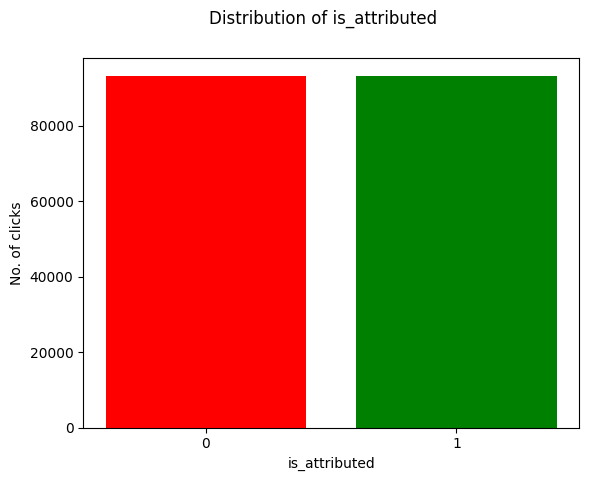

In [8]:
# Obtain counts of each class
data_0, data_1 = train["is_attributed"].value_counts()

# Plot distribution of is_attributed
fig, ax = plt.subplots()
fig.suptitle('Distribution of is_attributed')
labels = ['0', '1']
counts= [data_0, data_1]
ax.set_ylabel('No. of clicks')
ax.set_xlabel("is_attributed")
bars = ax.bar(labels, counts, color = ('red','green'))
plt.show()

## Feature Selection <a name="featureselection"></a>

In [9]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed',
       'day', 'hour', 'minute', 'second', 'uniq_app_per_ip_day',
       'uniq_os_per_ip_day', 'uniq_channel_per_ip_day', 'uniq_hour_per_ip_day',
       'uniq_os_per_ip_app', 'uniq_channel_per_ip_app', 'uniq_hour_per_ip_app',
       'uniq_app_per_ip_device_os', 'uniq_channel_per_ip_device_os',
       'uniq_hour_per_ip_device_os', 'uniq_app_per_ip', 'uniq_os_per_ip',
       'uniq_channel_per_ip', 'uniq_hour_per_ip', 'uniq_ip_per_app',
       'uniq_device_per_app', 'uniq_os_per_app', 'uniq_channel_per_app',
       'uniq_ip_per_device', 'uniq_app_per_device', 'uniq_os_per_device',
       'uniq_channel_per_device', 'uniq_ip_per_os', 'uniq_app_per_os',
       'uniq_device_per_os', 'uniq_channel_per_os', 'uniq_ip_per_channel',
       'uniq_app_per_channel', 'uniq_device_per_channel',
       'uniq_os_per_channel', 'ip_nextClick', 'ip_app_nextClick',
       'ip_device_nextClick', 'ip_os_nextClick', 'ip_channel_nextCli

In [10]:
X_train = train.drop(labels = 'is_attributed', axis = 1)
Y_train = train["is_attributed"]

In [11]:
X_train.dtypes

ip                               float64
app                              float64
device                           float64
os                               float64
channel                          float64
click_time                        object
day                                int64
hour                               int64
minute                             int64
second                             int64
uniq_app_per_ip_day              float64
uniq_os_per_ip_day               float64
uniq_channel_per_ip_day          float64
uniq_hour_per_ip_day             float64
uniq_os_per_ip_app               float64
uniq_channel_per_ip_app          float64
uniq_hour_per_ip_app             float64
uniq_app_per_ip_device_os        float64
uniq_channel_per_ip_device_os    float64
uniq_hour_per_ip_device_os       float64
uniq_app_per_ip                  float64
uniq_os_per_ip                   float64
uniq_channel_per_ip              float64
uniq_hour_per_ip                 float64
uniq_ip_per_app 

### Correlation between features

In [12]:
c = X_train.corr().abs()

s = c.unstack()
so = s.sort_values(ascending = False)
so = so.reset_index()
so.rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'correlation'}, inplace=True)

In [13]:
#remove correlation between the same features
filtered_so = so[so['feature_1'] != so['feature_2']]
filtered_so[filtered_so["correlation"] >= 0.9]

,feature_1,feature_2,correlation
54,uniq_app_per_device,uniq_ip_per_device,0.991723
55,uniq_ip_per_device,uniq_app_per_device,0.991723
56,device,uniq_os_per_device,0.989099
57,uniq_os_per_device,device,0.989099
58,device,uniq_ip_per_device,0.986470
...,...,...,...
125,uniq_os_per_ip,uniq_channel_per_ip,0.906414
126,channel,app_channel_counts,0.904232
127,app_channel_counts,channel,0.904232
128,uniq_os_per_ip_day,uniq_channel_per_ip_day,0.902328


In [14]:
train = train.drop(labels = ['uniq_ip_per_device', 'uniq_os_per_device','uniq_app_per_device',
                                'uniq_os_per_ip_day', 'uniq_channel_per_ip_device_os', 'uniq_app_per_ip_day',
                                'app_device_counts', 'device_channel_counts',
                                'uniq_app_per_device', 'uniq_channel_per_ip_day', 'uniq_channel_per_os',
                                'uniq_ip_per_os', 'uniq_channel_per_device', 'uniq_os_per_ip',
                                'ip_app_device_nextClick', 'app_hour_counts', 'uniq_hour_per_ip_device_os', 
                                'channel_hour_counts', 'uniq_hour_per_ip', 'app_channel_counts'], axis = 1)

Remaining columns

In [15]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed',
       'day', 'hour', 'minute', 'second', 'uniq_hour_per_ip_day',
       'uniq_os_per_ip_app', 'uniq_channel_per_ip_app', 'uniq_hour_per_ip_app',
       'uniq_app_per_ip_device_os', 'uniq_app_per_ip', 'uniq_channel_per_ip',
       'uniq_ip_per_app', 'uniq_device_per_app', 'uniq_os_per_app',
       'uniq_channel_per_app', 'uniq_app_per_os', 'uniq_device_per_os',
       'uniq_ip_per_channel', 'uniq_app_per_channel',
       'uniq_device_per_channel', 'uniq_os_per_channel', 'ip_nextClick',
       'ip_app_nextClick', 'ip_device_nextClick', 'ip_os_nextClick',
       'ip_channel_nextClick', 'device_hour_counts', 'cum_count_by_app',
       'cum_count_by_device', 'cum_count_by_channel'],
      dtype='object')

'click_time' is dropped due to no patterns observed in the above EDA. This can be due to the fact that observation is only over the span of 4 days.

In [16]:
train = train.drop("click_time", axis = 1)

Reload X_train with the updated train data

In [17]:
X_train = train.drop(labels = 'is_attributed', axis = 1)

### XGBoost Classifier 

In [18]:
from xgboost import XGBClassifier, plot_importance

xgb_model = XGBClassifier(random_state = 0)
xgb_model.fit(X_train, Y_train)
Y_train_pred = xgb_model.predict(X_train)

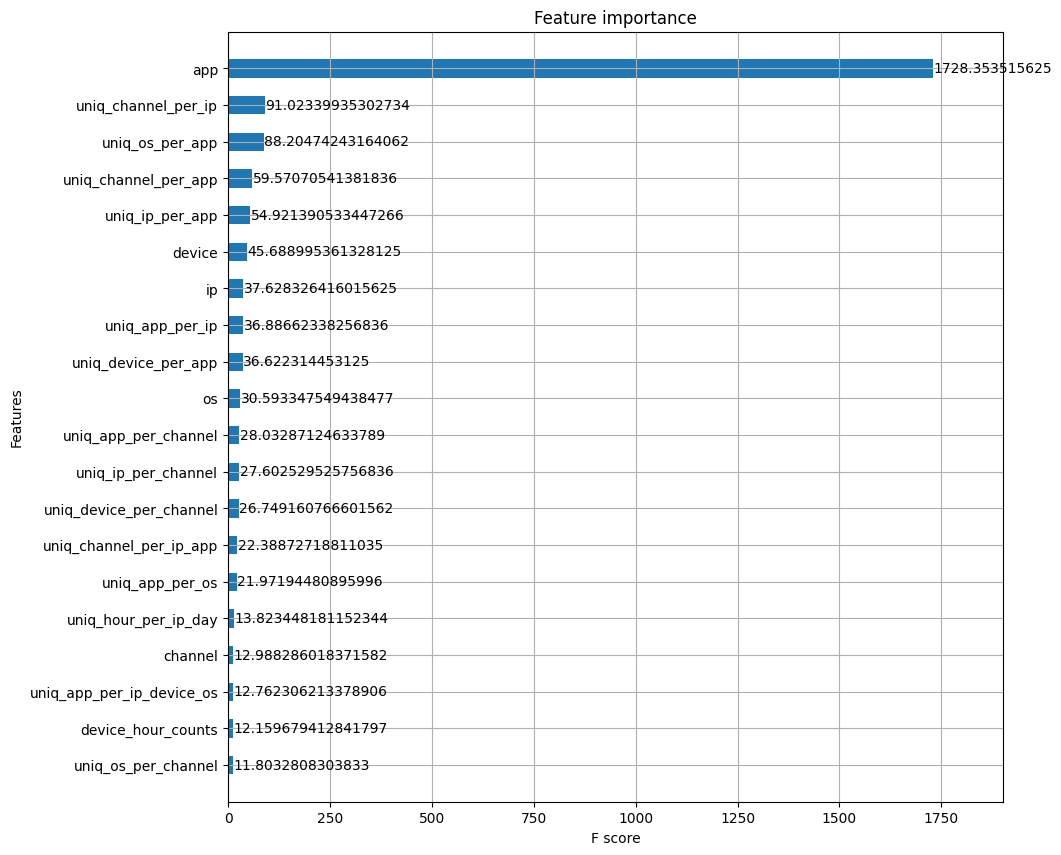

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(xgb_model, max_num_features = 20, height = 0.5, ax = ax,
                importance_type = "gain")
plt.show()

In [20]:
top_features = pd.DataFrame()
top_features['feature'] = X_train.columns
top_features['importance'] = xgb_model.feature_importances_
top_features.sort_values(by = 'importance', ascending=False, inplace=True)

top20_XGB_features = top_features[:20]
top20_XGB_features

,feature,importance
1,app,0.691871
15,uniq_channel_per_ip,0.036437
18,uniq_os_per_app,0.035309
19,uniq_channel_per_app,0.023847
16,uniq_ip_per_app,0.021985
2,device,0.018290
0,ip,0.015063
14,uniq_app_per_ip,0.014766
17,uniq_device_per_app,0.014660
3,os,0.012247


Although 'ip' is one of the top 20 features, we decided to drop 'ip' from our model as there is no significant difference observed between 'ip' in fraud and non-fraud click based on the EDA above.

In [21]:
final_features = list(top20_XGB_features.feature.values[top20_XGB_features.feature.values != 'ip'])

Datasets for model building and evaluation

In [22]:
final_features

['app',
 'uniq_channel_per_ip',
 'uniq_os_per_app',
 'uniq_channel_per_app',
 'uniq_ip_per_app',
 'device',
 'uniq_app_per_ip',
 'uniq_device_per_app',
 'os',
 'uniq_app_per_channel',
 'uniq_ip_per_channel',
 'uniq_device_per_channel',
 'uniq_channel_per_ip_app',
 'uniq_app_per_os',
 'uniq_hour_per_ip_day',
 'channel',
 'uniq_app_per_ip_device_os',
 'device_hour_counts',
 'uniq_os_per_channel']

## Prepare Testing Set <a name="preptest"></a>

The test set needs to be prepared as follows:
- Categorical Encoding
- Feature Engineering (features that seem helpful after EDA on train set)
- Feature selection (features selected using train set) (saved as 'test_final_features.csv')

#### Encode categorical variables

In [ ]:
test_sampled = pd.read_csv('./test_sampled.csv')
test_sampled.head()

In [3]:
# encoding test set, unknown categories are filled with 0
categorical_features = ['ip', 'app', 'device', 'os', 'channel']
new_test_cat = count_enc.transform(test_sampled[categorical_features])

new_test_cat.columns = ['ip_enc', 'app_enc', 'device_enc', 'os_enc', 'channel_enc']

test_enc = pd.concat([test_sampled, new_test_cat], axis = 1)

In [1]:
test_enc.to_csv("./test_enc.csv", index=False)

#### Create new features for testing set

In [3]:
test_sampled = pd.read_csv("./test_sampled.csv")

##### Extract time features from clicktime

In [4]:
# Create day, hour, minute, second features
test_datetime = pd.to_datetime(test_sampled['click_time'], format='%Y-%m-%d %H:%M:%S')
test_sampled['click_time'] = test_datetime
test_sampled['day'] = test_datetime.dt.day
test_sampled['hour'] = test_datetime.dt.hour
test_sampled['minute'] = test_datetime.dt.minute
test_sampled['second'] = test_datetime.dt.second
test_sampled.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,second
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,7
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,59
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,34
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,50
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,14


##### Unique counts features (Grp by Single Feature)

In [5]:
#getting the features required
unique_count_features = ['uniq_app_per_ip', 
                         'uniq_os_per_ip',
                         'uniq_channel_per_ip',
                         'uniq_hour_per_ip',
                         'uniq_ip_per_app',
                         'uniq_device_per_app',
                         'uniq_os_per_app',
                         'uniq_channel_per_app',
                         'uniq_ip_per_device',
                         'uniq_app_per_device',
                         'uniq_os_per_device',
                         'uniq_channel_per_device',
                         'uniq_ip_per_os',
                         'uniq_app_per_os',
                         'uniq_device_per_os',
                         'uniq_channel_per_os',
                         'uniq_ip_per_channel',
                         'uniq_app_per_channel',
                         'uniq_device_per_channel',
                         'uniq_os_per_channel']
unique = pd.DataFrame({"unique_count_features": unique_count_features })

#get the unique columns and group by columns
unique["split"] = unique["unique_count_features"].apply(lambda x: x.split("_"))
unique["group_col"] = unique["split"].apply(lambda x: x[3])
unique["unique_col"] = unique["split"].apply(lambda x: x[1])
unique.head()

,unique_count_features,split,group_col,unique_col
0,uniq_app_per_ip,"[uniq, app, per, ip]",ip,app
1,uniq_os_per_ip,"[uniq, os, per, ip]",ip,os
2,uniq_channel_per_ip,"[uniq, channel, per, ip]",ip,channel
3,uniq_hour_per_ip,"[uniq, hour, per, ip]",ip,hour
4,uniq_ip_per_app,"[uniq, ip, per, app]",app,ip


In [6]:
# Unique counts (same function as on the train set)
def agg_unique(df, group_cols, unique_col, name):
  grp = df[group_cols+[unique_col]].groupby(group_cols)[unique_col].nunique().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df

In [7]:
#get unique counts based on above combinations
for i in range(0,len(unique)):
    by_var = unique["group_col"][i]
    agg_var = unique["unique_col"][i]
    name = unique["unique_count_features"][i]
    print(f">>{name}")
    test_sampled = agg_unique(test_sampled, [by_var], agg_var, name)

test_sampled.head()

>>uniq_app_per_ip
>>uniq_os_per_ip
>>uniq_channel_per_ip
>>uniq_hour_per_ip
>>uniq_ip_per_app
>>uniq_device_per_app
>>uniq_os_per_app
>>uniq_channel_per_app
>>uniq_ip_per_device
>>uniq_app_per_device
>>uniq_os_per_device
>>uniq_channel_per_device
>>uniq_ip_per_os
>>uniq_app_per_os
>>uniq_device_per_os
>>uniq_channel_per_os
>>uniq_ip_per_channel
>>uniq_app_per_channel
>>uniq_device_per_channel
>>uniq_os_per_channel


,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,uniq_os_per_device,uniq_channel_per_device,uniq_ip_per_os,uniq_app_per_os,uniq_device_per_os,uniq_channel_per_os,uniq_ip_per_channel,uniq_app_per_channel,uniq_device_per_channel,uniq_os_per_channel
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,...,269,173,23707,82,3,149,16976,2,2,80
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,...,269,173,89252,154,3,163,41028,3,2,110
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,...,269,173,40485,103,3,154,58309,4,6,153
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,...,269,173,30179,79,3,148,49802,2,4,118
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,...,269,173,32568,99,3,154,26020,1,4,83


##### Unique Counts Featires (group by multiple feature)
['uniq_app_per_ip_day',
 'uniq_os_per_ip_day',
 'uniq_channel_per_ip_day',
 'uniq_hour_per_ip_day',
 'uniq_os_per_ip_app',
 'uniq_channel_per_ip_app',
 'uniq_hour_per_ip_app',
 'uniq_app_per_ip_device_os',
 'uniq_channel_per_ip_device_os',
 'uniq_hour_per_ip_device_os']

In [8]:
unique_count_features2 = ['uniq_app_per_ip_day',
                         'uniq_os_per_ip_day',
                         'uniq_channel_per_ip_day',
                         'uniq_hour_per_ip_day',
                         'uniq_os_per_ip_app',
                         'uniq_channel_per_ip_app',
                         'uniq_hour_per_ip_app',
                         'uniq_app_per_ip_device_os',
                         'uniq_channel_per_ip_device_os',
                         'uniq_hour_per_ip_device_os']
unique2 = pd.DataFrame({"unique_count_features": unique_count_features2 })

# get unique cols and group by cols for input to function
unique2["split"] = unique2["unique_count_features"].apply(lambda x: x.split("_"))
unique2["group_col"] = unique2["split"].apply(lambda x: x[3:len(x)])
unique2["unique_col"] = unique2["split"].apply(lambda x: x[1])
unique2.head()

,unique_count_features,split,group_col,unique_col
0,uniq_app_per_ip_day,"[uniq, app, per, ip, day]","[ip, day]",app
1,uniq_os_per_ip_day,"[uniq, os, per, ip, day]","[ip, day]",os
2,uniq_channel_per_ip_day,"[uniq, channel, per, ip, day]","[ip, day]",channel
3,uniq_hour_per_ip_day,"[uniq, hour, per, ip, day]","[ip, day]",hour
4,uniq_os_per_ip_app,"[uniq, os, per, ip, app]","[ip, app]",os


In [9]:
for i in range(0,len(unique2)):
    by_var = unique2["group_col"][i]
    agg_var = unique2["unique_col"][i]
    name = unique2["unique_count_features"][i]
    print(f">>{name}")
    test_sampled = agg_unique(test_sampled, by_var, agg_var, name)
    
test_sampled.head()

>>uniq_app_per_ip_day
>>uniq_os_per_ip_day
>>uniq_channel_per_ip_day
>>uniq_hour_per_ip_day
>>uniq_os_per_ip_app
>>uniq_channel_per_ip_app
>>uniq_hour_per_ip_app
>>uniq_app_per_ip_device_os
>>uniq_channel_per_ip_device_os
>>uniq_hour_per_ip_device_os


,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,uniq_app_per_ip_day,uniq_os_per_ip_day,uniq_channel_per_ip_day,uniq_hour_per_ip_day,uniq_os_per_ip_app,uniq_channel_per_ip_app,uniq_hour_per_ip_app,uniq_app_per_ip_device_os,uniq_channel_per_ip_device_os,uniq_hour_per_ip_device_os
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,...,23,25,58,16,15,13,18,5,7,5
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,...,19,18,42,18,18,17,19,18,45,17
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,...,11,14,30,19,10,5,10,7,10,6
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,...,23,23,55,23,11,4,19,3,3,3
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,...,14,12,20,13,5,5,7,3,3,2


##### Cumulative Count Features
['cum_count_by_app', 'cum_count_by_device','cum_count_by_channel']

In [10]:
# Cumulative counts
def agg_cum_count(df, group_cols, name):
    grp = df[group_cols].groupby(group_cols).cumcount()
    df[name] = grp.values
    return df

In [11]:
combi = ['app', 'device', 'channel']

for var in combi:
    print(f">> Creating cum_count_by_{var}")
    test_sampled = agg_cum_count(test_sampled, [var], f"cum_count_by_{var}")

test_sampled.head()

>> Creating cum_count_by_app
>> Creating cum_count_by_device
>> Creating cum_count_by_channel


,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,uniq_hour_per_ip_day,uniq_os_per_ip_app,uniq_channel_per_ip_app,uniq_hour_per_ip_app,uniq_app_per_ip_device_os,uniq_channel_per_ip_device_os,uniq_hour_per_ip_device_os,cum_count_by_app,cum_count_by_device,cum_count_by_channel
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,...,16,15,13,18,5,7,5,0,0,0
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,...,18,18,17,19,18,45,17,0,1,0
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,...,19,10,5,10,7,10,6,0,2,0
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,...,23,11,4,19,3,3,3,1,3,0
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,...,13,5,5,7,3,3,2,0,4,0


##### Total Counts Features

['app_device_counts', 'app_channel_counts', 'app_hour_counts', 'device_channel_counts', 'device_hour_counts', 'channel_hour_counts']

In [12]:
# Total counts
def agg_counts(df, group_cols, name):
  grp = df[group_cols].groupby(group_cols).size().rename(name).to_frame().reset_index()
  df = df.merge(grp, on=group_cols, how="left")
  return df

In [13]:
combi = [["app", "device"],
         ["app", "channel"],
         ["app", "hour"],
         ["device", "channel"],
         ["device", "hour"],
         ["channel", "hour"]]

for var in combi:
    print(f">> Creating {'_'.join(var)}_counts")
    test_sampled = agg_counts(test_sampled, list(var), f"{'_'.join(var)}_counts")

test_sampled.head()

>> Creating app_device_counts
>> Creating app_channel_counts
>> Creating app_hour_counts
>> Creating device_channel_counts
>> Creating device_hour_counts
>> Creating channel_hour_counts


,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,uniq_hour_per_ip_device_os,cum_count_by_app,cum_count_by_device,cum_count_by_channel,app_device_counts,app_channel_counts,app_hour_counts,device_channel_counts,device_hour_counts,channel_hour_counts
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,...,5,0,0,0,777223,29820,39444,29697,467031,1636
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,...,17,0,1,0,1658476,64432,108947,133760,478562,7271
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,...,6,0,2,0,767062,399294,38055,398939,465927,18942
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,...,3,1,3,0,767062,166254,43164,237603,420984,10483
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,...,2,0,4,0,794967,63513,53107,58633,444611,2948


##### Time till next click feature

['ip_nextClick', 'ip_app_nextClick', 'ip_device_nextClick', 'ip_os_nextClick', 'ip_channel_nextClick', 'ip_app_device_nextClick',]

In [14]:
def time_till_next(df, group_cols, name):
    df_sub = df[group_cols+['click_time']]
    df[name] = df_sub.groupby(group_cols).click_time.transform(lambda x: x.diff().shift(-1)).dt.seconds
    df[name].fillna(0, inplace=True)
    return df

In [15]:
combi = [["ip"],
         ["ip", "app"],
         ["ip", "device"],
         ["ip", "os"],
         ["ip", "channel"],
         ["ip", "app", "device"]]

for var in combi:
    print(f">> Creating {'_'.join(var)}_nextClick")
    test_sampled = time_till_next(test_sampled, var, f"{'_'.join(var)}_nextClick")

test_sampled.head()

>> Creating ip_nextClick
>> Creating ip_app_nextClick
>> Creating ip_device_nextClick
>> Creating ip_os_nextClick
>> Creating ip_channel_nextClick
>> Creating ip_app_device_nextClick


,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,app_hour_counts,device_channel_counts,device_hour_counts,channel_hour_counts,ip_nextClick,ip_app_nextClick,ip_device_nextClick,ip_os_nextClick,ip_channel_nextClick,ip_app_device_nextClick
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,...,39444,29697,467031,1636,31945.0,26242.0,31945.0,34837.0,0.0,26242.0
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,...,108947,133760,478562,7271,38780.0,21921.0,38780.0,64119.0,34514.0,21921.0
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,...,38055,398939,465927,18942,14807.0,6466.0,14807.0,4961.0,6466.0,6466.0
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,...,43164,237603,420984,10483,373.0,10809.0,373.0,69966.0,10809.0,10809.0
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,...,53107,58633,444611,2948,40571.0,1946.0,40571.0,78833.0,1946.0,1946.0


##### End of feature engineering on test set (save to csv file)

In [16]:
test_sampled.to_csv("test_features.csv", index=False)

#### Min-Max Scaling on newly created features

Usage of the min and max values of features obtained from train set

In [17]:
test_sampled = pd.read_csv("test_features.csv")
min_max = pd.read_csv("minmax_values.csv")
min_max.head()

,Features,Max,Min
0,uniq_app_per_ip_day,138.0,1.0
1,uniq_os_per_ip_day,120.0,1.0
2,uniq_channel_per_ip_day,139.0,1.0
3,uniq_hour_per_ip_day,24.0,1.0
4,uniq_os_per_ip_app,106.0,1.0


In [18]:
def min_max_scale(test, min_max):
    for i in range(0, len(min_max)):
        min = min_max["Min"][i]
        max = min_max["Max"][i]
        feature = min_max["Features"][i]
        test[feature] = (test[feature] - min)/(max - min)
    return test

In [19]:
test = min_max_scale(test_sampled, min_max)
test.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,app_hour_counts,device_channel_counts,device_hour_counts,channel_hour_counts,ip_nextClick,ip_app_nextClick,ip_device_nextClick,ip_os_nextClick,ip_channel_nextClick,ip_app_device_nextClick
0,18839,15,1,32,430,2017-11-09 03:29:07,0,9,3,29,...,0.081967,0.010310,0.203400,0.006304,0.369738,0.303730,0.369738,0.403211,0.000000,0.303730
1,198976,3,1,19,480,2017-11-08 05:42:59,0,8,5,42,...,0.226402,0.046437,0.208422,0.028030,0.448848,0.253718,0.448848,0.742127,0.399472,0.253718
2,186326,18,1,25,107,2017-11-07 02:56:34,0,7,2,56,...,0.079080,0.138499,0.202919,0.073028,0.171379,0.074839,0.171379,0.057420,0.074839,0.074839
3,21960,18,1,1,121,2017-11-07 09:45:50,0,7,9,45,...,0.089698,0.082488,0.183346,0.040414,0.004317,0.125106,0.004317,0.809801,0.125106,0.125106
4,71447,9,1,14,244,2017-11-09 12:32:14,0,9,12,32,...,0.110360,0.020355,0.193636,0.011362,0.469577,0.022523,0.469577,0.912430,0.022523,0.022523


#### Combine with Categorical Encoding

In [21]:
test_enc  = pd.read_csv("test_enc.csv")

In [22]:
cat_features = ['ip', 'app', 'device', 'os', 'channel']
cat_features_enc = ['ip_enc', 'app_enc', 'device_enc', 'os_enc', 'channel_enc']

for i in range(0,len(cat_features)):
    test[cat_features[i]] = test_enc[cat_features_enc[i]]

test.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,...,app_hour_counts,device_channel_counts,device_hour_counts,channel_hour_counts,ip_nextClick,ip_app_nextClick,ip_device_nextClick,ip_os_nextClick,ip_channel_nextClick,ip_app_device_nextClick
0,0.000053,0.085924,0.942435,0.009001,0.003183,2017-11-09 03:29:07,0,9,3,29,...,0.081967,0.010310,0.203400,0.006304,0.369738,0.303730,0.369738,0.403211,0.000000,0.303730
1,0.000027,0.181819,0.942435,0.238728,0.014188,2017-11-08 05:42:59,0,8,5,42,...,0.226402,0.046437,0.208422,0.028030,0.448848,0.253718,0.448848,0.742127,0.399472,0.253718
2,0.000020,0.085729,0.942435,0.022487,0.046148,2017-11-07 02:56:34,0,7,2,56,...,0.079080,0.138499,0.202919,0.073028,0.171379,0.074839,0.171379,0.057420,0.074839,0.074839
3,0.000044,0.085729,0.942435,0.011979,0.025664,2017-11-07 09:45:50,0,7,9,45,...,0.089698,0.082488,0.183346,0.040414,0.004317,0.125106,0.004317,0.809801,0.125106,0.125106
4,0.000006,0.090708,0.942435,0.013570,0.006714,2017-11-09 12:32:14,0,9,12,32,...,0.110360,0.020355,0.193636,0.011362,0.469577,0.022523,0.469577,0.912430,0.022523,0.022523


#### Convert Processed Test Set to CSV file

In [23]:
test.to_csv('./test_processed.csv', index=False)

#### Select features for test set (using features selected from training data)

In [6]:
final_features_test = ['is_attributed',
                       'app',
                       'uniq_channel_per_ip',
                       'uniq_os_per_app',
                       'uniq_channel_per_app',
                       'uniq_ip_per_app',
                       'device',
                       'uniq_app_per_ip',
                       'uniq_device_per_app',
                       'os',
                       'uniq_app_per_channel',
                       'uniq_ip_per_channel',
                       'uniq_device_per_channel',
                       'uniq_channel_per_ip_app',
                       'uniq_app_per_os',
                       'uniq_hour_per_ip_day',
                       'channel',
                       'uniq_app_per_ip_device_os',
                       'device_hour_counts',
                       'uniq_os_per_channel']

In [19]:
test = pd.read_csv('./test_processed.csv')
test_final_features = test[final_features_test]

In [21]:
test_final_features.to_csv("./test_final_features.csv", index = False)

## Load train and test set

In [24]:
#training
x_train = train[final_features]
y_train = train["is_attributed"]

print(x_train.shape, y_train.shape)

(186454, 19) (186454,)


In [29]:
#testing
test = pd.read_csv("test_final_features.csv")

x_test = test.drop("is_attributed", axis = 1)
y_test = test["is_attributed"]

print(x_test.shape, y_test.shape)

(9450051, 19) (9450051,)


## Model Building <a name="modelbuilding"></a>

The following models will be evaluated for this classification problem:
1. Logistic Regression
2. K Nearest Neighbours (KNN)
3. Neural Network
4. Random Forest Classifier
5. XGBoost Classifier

In [4]:
def evaluation_metrics(y_actual, y_pred, y_score):
    cm = metrics.confusion_matrix(y_actual, y_pred)
    accuracy = metrics.accuracy_score(y_actual, y_pred)
    precision = metrics.precision_score(y_actual, y_pred)
    recall = metrics.recall_score(y_actual, y_pred)
    f2 = metrics.fbeta_score(y_actual, y_pred, beta=2.0)
    roc_auc = metrics.roc_auc_score(y_actual, y_score)
    
    dct = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F2': f2,
        'ROC_AUC': roc_auc
    }
    
    # Confusion matrix
    print('Confusion matrix:\n', cm, '\n')
    
    # Accuracy
    print('Accuracy:', accuracy, '\n')
    
    # Precision
    print('Precision:', precision, '\n')
    
    # Recall
    print('Recall:', recall, '\n')
    
    # F2 Score
    print('F2 Score:', f2, '\n')
    
    # ROC_AUC Score
    print('ROC_AUC Score:', roc_auc)
    
    return dct

### Logistic Regression <a name="lr"></a>

#### Baseline model with 19 features

In [56]:
lr = LogisticRegression(random_state=0, max_iter = 2000)

lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_train_pred_score = lr.predict_proba(x_train)[:, 1]

In [57]:
evaluation_metrics(y_train,y_train_pred_lr, y_train_pred_score)

Confusion matrix:
 [[88176  5051]
 [11861 81366]] 

Accuracy: 0.9092966629838996 

Precision: 0.941550852262865 

Recall: 0.8727729091357654 

F2 Score: 0.8857127306373481 

ROC_AUC Score: 0.9511534616781476


{'Accuracy': 0.9092966629838996,
 'Precision': 0.941550852262865,
 'Recall': 0.8727729091357654,
 'F2': 0.8857127306373481,
 'ROC_AUC': 0.9511534616781476}

#### Tuned model

In [61]:
y_train = train['is_attributed']
evaluation_scores = [['num_features', 'roc_auc_score', 'f2']]
for i in range(19,3,-5):
    x_train_trial = train[final_features[:i]]
    lr = LogisticRegression(random_state=0, max_iter=2000)
    param_grid = {'penalty' : ['l2','none'],
              'C' : np.logspace(-2, 2, 5),
              'solver' : ['sag','saga']}
    clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, n_jobs = -1)
    lr_tuned = clf_lr.fit(x_train_trial,y_train)
    # summarize results
    print("For %d features, best: %f using %s \n" % (i, lr_tuned.best_score_, lr_tuned.best_params_))
    y_train_pred_tunedlr = lr_tuned.predict(x_train_trial)
    y_train_pred_score = lr_tuned.predict_proba(x_train_trial)[:, 1]
    evaluation = evaluation_metrics(y_train,y_train_pred_tunedlr, y_train_pred_score)
    evaluation
    roc_auc = evaluation['ROC_AUC']
    f2 =  evaluation['F2']
    evaluation_scores.append([i, roc_auc, f2])    
evaluation_scores = pd.DataFrame(evaluation_scores[1:],columns=evaluation_scores[0])

For 19 features, best: 0.909511 using {'C': 0.01, 'penalty': 'none', 'solver': 'sag'}
Confusion matrix:
 [[88164  5063]
 [11807 81420]] 

Accuracy: 0.9095219196155621 

Precision: 0.9414567024733185 

Recall: 0.8733521404743261 

F2 Score: 0.8861732162798139 

ROC_AUC Score: 0.9510093282556036
For 14 features, best: 0.908229 using {'C': 10.0, 'penalty': 'l2', 'solver': 'saga'}
Confusion matrix:
 [[88020  5207]
 [11905 81322]] 

Accuracy: 0.9082240123569352 

Precision: 0.939823642940517 

Recall: 0.8723009428599011 

F2 Score: 0.8850179676430066 

ROC_AUC Score: 0.9496057681836192
For 9 features, best: 0.900335 using {'C': 0.01, 'penalty': 'none', 'solver': 'sag'}
Confusion matrix:
 [[87635  5592]
 [13002 80225]] 

Accuracy: 0.9002756712111298 

Precision: 0.9348380856939768 

Recall: 0.8605339654821028 

F2 Score: 0.874434574091231 

ROC_AUC Score: 0.9477487679469856
For 4 features, best: 0.881622 using {'C': 10.0, 'penalty': 'l2', 'solver': 'sag'}
Confusion matrix:
 [[85537  7690]
 [

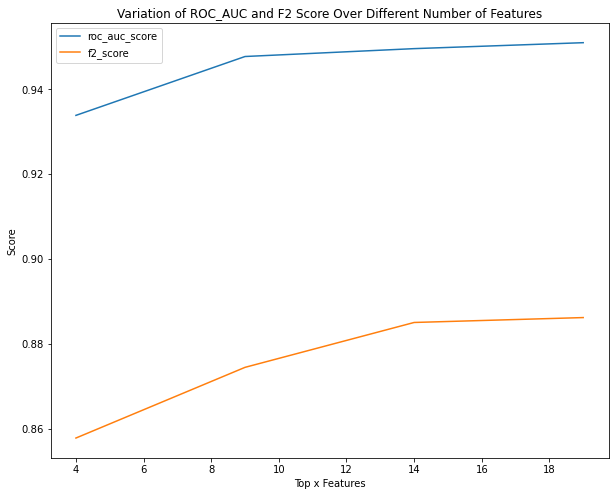

In [75]:
fig, ax = plt.subplots(figsize=(10,8))
x = evaluation_scores['num_features']
plt.plot(x, evaluation_scores['roc_auc_score'], label = "roc_auc_score")
plt.plot(x, evaluation_scores['f2'], label = "f2_score")
plt.title("Variation of ROC_AUC and F2 Score Over Different Number of Features")
plt.xlabel("Top x Features")
plt.ylabel("Score")
plt.legend()
plt.show()

In [61]:
final_9_features = final_features[:9]

In [62]:
lr_tuned = LogisticRegression(random_state=0, max_iter=2000, C = 0.01, penalty= 'none', solver= 'sag')

lr_tuned.fit(x_train[final_9_features], y_train)
y_train_pred_tunedlr = lr_tuned.predict(x_train[final_9_features])
y_train_pred_score = lr_tuned.predict_proba(x_train[final_9_features])[:,1]
evaluation_metrics(y_train,y_train_pred_tunedlr, y_train_pred_score)

Confusion matrix:
 [[87635  5592]
 [13002 80225]] 

Accuracy: 0.9002756712111298 

Precision: 0.9348380856939768 

Recall: 0.8605339654821028 

F2 Score: 0.874434574091231 

ROC_AUC Score: 0.9477487679469856


{'Accuracy': 0.9002756712111298,
 'Precision': 0.9348380856939768,
 'Recall': 0.8605339654821028,
 'F2': 0.874434574091231,
 'ROC_AUC': 0.9477487679469856}

In [73]:
#check on test data
y_test_pred = lr_tuned.predict(x_test[final_9_features])
y_test_pred_score = lr_tuned.predict_proba(x_test[final_9_features])[:,1]

In [74]:
evaluation_metrics(y_test,y_test_pred, y_test_pred_score)

Confusion matrix:
 [[1729218 7697526]
 [    324   22983]] 

Accuracy: 0.18541709457441025 

Precision: 0.0029768762655415595 

Recall: 0.9860985969880294 

F2 Score: 0.014706791385479189 

ROC_AUC Score: 0.9338560722844573


{'Accuracy': 0.18541709457441025,
 'Precision': 0.0029768762655415595,
 'Recall': 0.9860985969880294,
 'F2': 0.014706791385479189,
 'ROC_AUC': 0.9338560722844573}

### K Nearest Neighbours (KNN) <a name="knn"></a>

#### Baseline with 9 features

In [14]:
X_train_9 = X_train[final_features[:9]]

In [16]:
#fit KNN classifier to the training set
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  
knn.fit(X_train_9, y_train)
#predict the train set
y_pred = knn.predict(X_train_9)
y_pred_score = knn.predict_proba(X_train_9)[:, 1]
#compute evaluation metrics
knn_basic = evaluation_metrics(y_train, y_pred, y_pred_score)

Confusion matrix:
 [[89968  3259]
 [12761 80466]] 

Accuracy: 0.9140806847801602 

Precision: 0.9610749477455957 

Recall: 0.8631190534930868 

F2 Score: 0.8810795540401153 

ROC_AUC Score: 0.976220637423227


{'Accuracy': 0.9140806847801602,
 'Precision': 0.9610749477455957,
 'Recall': 0.8631190534930868,
 'F2': 0.8810795540401153,
 'ROC_AUC': 0.976220637423227}

#### Tune KNN model

In [20]:
estimator_KNN = KNeighborsClassifier(algorithm='auto') # ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.
parameters_KNN = {
    'n_neighbors': (1,10, 1), # Number of neighbors to use.
    'leaf_size': (20,40,1), # This can affect the speed of the construction and query, as well as the memory required to store the tree.
    'p': (1,2), # When p = 1, this is equivalent to using manhattan_distance, and euclidean_distance for p = 2.
    'weights': ('uniform', 'distance'), # 'uniform': uniform weights. All points in each neighborhood are weighted equally.
                                        #'distance': weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
    'metric': ('minkowski', 'chebyshev')}
                   
# with GridSearch
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    cv = 5)

grid_search_KNN.fit(X_train_9, y_train)
print(grid_search_KNN.best_estimator_)
print(grid_search_KNN.best_params_)
print(grid_search_KNN.best_score_)

KNeighborsClassifier(leaf_size=40, n_neighbors=10, p=1)
{'leaf_size': 40, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
0.9121821203144391


In [25]:
#fit KNN classifier to the training set
knn_tuned = KNeighborsClassifier(**{'leaf_size': 40, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'})  
knn_tuned.fit(X_train_9, y_train)
#predict the train set
y_pred_tuned = knn_tuned.predict(X_train_9)
y_pred_score_tuned = knn_tuned.predict_proba(X_train_9)[:, 1]
#compute evaluation metrics
knn_metric = evaluation_metrics(y_train, y_pred_tuned, y_pred_score_tuned)

Confusion matrix:
 [[90328  2899]
 [13117 80110]] 

Accuracy: 0.9141021377926996 

Precision: 0.9650760760881351 

Recall: 0.8593004172610939 

F2 Score: 0.8785590359648796 

ROC_AUC Score: 0.9772264469252328


#### Evaluate on testing set

In [23]:
X_test_9 = x_test[final_features[:9]]

In [26]:
y_pred_tuned_test = knn_tuned.predict(X_test_9)
y_pred_score_tuned_test = knn_tuned.predict_proba(X_test_9)[:, 1]
#compute evaluation metrics
knn_metric_test = evaluation_metrics(y_test, y_pred_tuned_test, y_pred_score_tuned_test)

Confusion matrix:
 [[7837107 1589637]
 [   2294   21013]] 

Accuracy: 0.8315426022568555 

Precision: 0.013046285661068512 

Recall: 0.9015746342300597 

F2 Score: 0.061662278637320274 

ROC_AUC Score: 0.916209751788032


### Neural Network <a name="nn"></a>

For neural network, we will be performing hyperparamter tuning using **bayesian optimisation**

As tuning the hyperparameters is computationally expensive, bayesian optimiation is chosen as it is an informed search method, and tend to reduce the number of iterations needed to find parameters close to the optimal which is more efficient.

Reference:
https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

#### Top 9 features

In [25]:
x_train_9 = x_train[final_features[:9]]
x_train_9.head(3)

,app,uniq_channel_per_ip,uniq_os_per_app,uniq_channel_per_app,uniq_ip_per_app,device,uniq_app_per_ip,uniq_device_per_app,os
0,0.085924,0.653333,0.724696,0.651163,0.810348,0.942435,0.174359,0.002621,0.001422
1,0.181819,0.660000,0.870445,0.953488,1.000000,0.942435,0.210256,0.003145,0.214987
2,0.117137,0.493333,1.000000,0.558140,0.863181,0.942435,0.133333,0.002621,0.238728


In [33]:
x_test_9 = x_test[final_features[:9]]
x_test_9.head(3)

,app,uniq_channel_per_ip,uniq_os_per_app,uniq_channel_per_app,uniq_ip_per_app,device,uniq_app_per_ip,uniq_device_per_app,os
0,0.085924,0.540000,0.562753,0.674419,0.586017,0.942435,0.138462,0.002621,0.009001
1,0.181819,0.453333,0.684211,0.930233,0.716431,0.942435,0.128205,0.003145,0.238728
2,0.085729,0.400000,0.627530,0.348837,0.581622,0.942435,0.102564,0.002621,0.022487


Import necessary packages

In [30]:
#pip install git+https://github.com/fmfn/BayesianOptimization

In [27]:
LeakyReLU = LeakyReLU(alpha=0.1)
score_acc = make_scorer(accuracy_score)

#### Tune hyperparameters of the neural network

Hyperparameters to tune:
- Number of layers
- Number of neurons
- Activation Function
- Optimizer + learning rate
- Batch_size
- Epochs
- Drop_out
- Normalization

In [28]:
# Create function (consider layer)
def nn_bo_func(neurons, activation, optimizer, learning_rate, batch_size, epochs, layers1, layers2, normalization, dropout, dropout_rate):
    # optimizer
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
    optimizerD= {'SGD':SGD(learning_rate=learning_rate), 'Adam':Adam(learning_rate=learning_rate), 
                 'RMSprop':RMSprop(learning_rate=learning_rate), 'Adadelta':Adadelta(learning_rate=learning_rate),
                 'Adagrad':Adagrad(learning_rate=learning_rate), 'Adamax':Adamax(learning_rate=learning_rate),
                 'Nadam':Nadam(learning_rate=learning_rate), 'Ftrl':Ftrl(learning_rate=learning_rate)}
    
    # activation function
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential', LeakyReLU]
    
    #other hyperparameters
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)

    #structure of deep neural network
    def nn():
        nn = Sequential()
        nn.add(Dense(neurons, input_dim=x_train_9.shape[1], activation=activation))
        if normalization > 0.5:
            nn.add(BatchNormalization()) # It serves to speed up training and use higher learning rates
        for i in range(layers1):
            nn.add(Dense(neurons, activation=activation))
        if dropout > 0.5:
            nn.add(Dropout(dropout_rate, seed=1))
        for i in range(layers2):
            nn.add(Dense(neurons, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return nn
        
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=10) # EarlyStopping is used to stop the learning process if there is no accuracy improvement in 20 epochs
    nn = KerasClassifier(build_fn=nn, epochs=epochs, batch_size=batch_size, verbose=0)
    
    #uses cv to choose best hyperparaters
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    score = cross_val_score(nn, x_train_9, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()

    return score

In [29]:
# Set paramaters (consider layer)
params_grid ={
    'neurons': (1, 32),
    'activation':(0, 8),
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size':(200, 1000),
    'epochs':(20, 100),
    'layers1':(0,5),
    'layers2':(0,5),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.5)
}

# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_bo_func, params_grid, random_state=0)
nn_bo.maximize(init_points=25, n_iter=5)

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
1166/1166 [==============================] - 1s 509us/step
| 1         | 0.5825    | 4.391     | 772.2     | 0.6028    | 0.2724    | 53.89     | 3.229     | 2.188     | 0.8929    | 30.87     | 0.3834    | 5.542     |
1166/1166 [==============================] - 1s 537us/step
| 2         | 0.501     | 4.231     | 654.4     | 0.9256    | 0.03552   | 26.97     | 0.1011    | 4.163     | 0.7804    | 27.97     | 0.9786    | 5.594     |
1166/1166 [==============================] - 1s 546us/step
| 3         | 0.913     | 3.692     | 824.4     | 0.1183    | 0.32      | 31.47     | 4.723     | 2.609     | 0.4205    | 9.201     | 0.7742    | 3.193     |
1166/1166 [======================

In [30]:
params_nn = nn_bo.max['params']

#activation
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU]
params_nn['activation'] = activationL[round(params_nn['activation'])]

#iteration
params_nn['batch_size'] = round(params_nn['batch_size'])
params_nn['epochs'] = round(params_nn['epochs'])

#layers, neurons
params_nn['layers1'] = round(params_nn['layers1'])
params_nn['layers2'] = round(params_nn['layers2'])
params_nn['neurons'] = round(params_nn['neurons'])

#optimizer
learning_rate3 = params_nn['learning_rate']
optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
optimizerD= {'SGD':SGD(learning_rate=learning_rate3), 'Adam':Adam(learning_rate=learning_rate3), 
             'RMSprop':RMSprop(learning_rate=learning_rate3), 'Adadelta':Adadelta(learning_rate=learning_rate3),
             'Adagrad':Adagrad(learning_rate=learning_rate3), 'Adamax':Adamax(learning_rate=learning_rate3),
             'Nadam':Nadam(learning_rate=learning_rate3), 'Ftrl':Ftrl(learning_rate=learning_rate3)}
params_nn['optimizer'] = optimizerD[optimizerL[round(params_nn['optimizer'])]]

params_nn

{'activation': 'selu',
 'batch_size': 215,
 'dropout': 0.6176354970758771,
 'dropout_rate': 0.3060478613612107,
 'epochs': 69,
 'layers1': 5,
 'layers2': 3,
 'learning_rate': 0.36591282156804816,
 'neurons': 15,
 'normalization': 0.6976311959272649,
 'optimizer': <keras.optimizers.optimizer_v2.gradient_descent.SGD at 0x1bee1123cd0>}

In [34]:
score = nn_bo_func(**nn_bo.max['params'])
print(f'Cross validation score: {score}')

1166/1166 [==============================] - 1s 606us/step
Cross validation score: 0.837968946930895


#### Tuned Deep Neural Network

In [35]:
#hyperparameters
best_params = params_nn
activation = best_params["activation"]
batch_size =  best_params["batch_size"]
dropout = best_params["dropout"]
dropout_rate = best_params["dropout_rate"]
epochs = best_params["epochs"]
layers1 = best_params["layers1"]
layers2 = best_params["layers2"]
neurons = best_params["neurons"]
normalization = best_params["normalization"]
optimizer = best_params["optimizer"]

In [36]:
# Neural Network with tuned hyperparamters
nn = Sequential()
nn.add(Dense(neurons, input_dim=x_train_9.shape[1], activation=activation))
if normalization > 0.5:
    nn.add(BatchNormalization())
for i in range(layers1):
    nn.add(Dense(neurons, activation=activation))
if dropout > 0.5:
    nn.add(Dropout(dropout_rate, seed=1))
for i in range(layers2):
    nn.add(Dense(neurons, activation=activation))
nn.add(Dense(1, activation='sigmoid'))
nn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [37]:
#fit model
es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=10) 
nn.fit(x_train_9, y_train, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)

In [45]:
# train set evaluation
model_pred_prob_train = nn.predict(x_train_9)

# make class predictions with the model
y_pred_nn_train = (model_pred_prob_train > 0.5).astype(int)

#train evaluation
evaluation_metrics(y_train, y_pred_nn_train, model_pred_prob_train)

5827/5827 [==============================] - 4s 610us/step
Confusion matrix:
 [[88628  4599]
 [ 9694 83533]] 

Accuracy: 0.923343022943997 

Precision: 0.9478169109971406 

Recall: 0.8960172482220816 

F2 Score: 0.9059192260975186 

ROC_AUC Score: 0.9683304812486244


{'Accuracy': 0.923343022943997,
 'Precision': 0.9478169109971406,
 'Recall': 0.8960172482220816,
 'F2': 0.9059192260975186,
 'ROC_AUC': 0.9683304812486244}

In [38]:
# test set evaluation
model_pred_prob = nn.predict(x_test_9)

# make class predictions with the model
y_pred_nn = (model_pred_prob > 0.5).astype(int)

295315/295315 [==============================] - 165s 560us/step


In [42]:
#test evaluation
nn_metric_test = evaluation_metrics(y_test, y_pred_nn, model_pred_prob)

Confusion matrix:
 [[5063948 4362796]
 [   1301   22006]] 

Accuracy: 0.5381932859409965 

Precision: 0.0050186986778422375 

Recall: 0.9441798601278586 

F2 Score: 0.024571072547526475 

ROC_AUC Score: 0.9224579012820288


### Random Forest Classifier <a name="rf"></a>

In [30]:
final_9_features = final_features[:9]
x_train = x_train[final_9_features]
x_test = x_test[final_9_features]

In [36]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(x_train, y_train)
y_pred_train_rfc = rfc.predict(x_train)
y_pred_train_score_rfc = rfc.predict_proba(x_train)[:, 1]

In [37]:
evaluation_metrics(y_train, y_pred_train_rfc, y_pred_train_score_rfc)

Confusion matrix:
 [[93227     0]
 [    0 93227]] 

Accuracy: 1.0 

Precision: 1.0 

Recall: 1.0 

F2 Score: 1.0 

ROC_AUC Score: 1.0


{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F2': 1.0, 'ROC_AUC': 1.0}

In [38]:
print('Parameters currently in use:\n')
print(rfc.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


#### Hyperparameter tuning with Grid Search

In [50]:
# Grid Search
rfc = RandomForestClassifier(random_state = 0)

# Create the parameter grid
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_leaf': [10, 20, 30, 40, 50],
    'min_samples_split': [2500, 5000, 7500, 10000],
    'n_estimators': [10, 20, 30]
}

# Instantiate the grid search model
rfc_grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5, n_jobs = -1)

In [51]:
rfc_grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50],
                         'min_samples_leaf': [10, 20, 30, 40, 50],
                         'min_samples_split': [2500, 5000, 7500, 10000],
                         'n_estimators': [10, 20, 30]})

In [52]:
print(rfc_grid_search.best_estimator_)
print(rfc_grid_search.best_params_)
print(rfc_grid_search.best_score_)

RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=30,
                       min_samples_split=2500, n_estimators=10, random_state=0)
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 2500, 'n_estimators': 10}
0.9193581310620015


In [74]:
# fit best RandomForestClassifier on training set
rfc_tuned = RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=30,
                       min_samples_split=2500, n_estimators=10, random_state=0)

rfc_tuned.fit(x_train, y_train)

y_pred_train_rfc_tuned = rfc_tuned.predict(x_train)
y_pred_train_rfc_tuned_score = rfc_tuned.predict_proba(x_train)[:, 1]

rfc_train_scores = evaluation_metrics(y_train, y_pred_train_rfc_tuned, y_pred_train_rfc_tuned_score)

Confusion matrix:
 [[89595  3632]
 [11214 82013]] 

Accuracy: 0.9203771439604407 

Precision: 0.9575923871796369 

Recall: 0.8797129586922243 

F2 Score: 0.8942586789313341 

ROC_AUC Score: 0.9683776929142833


{'Accuracy': 0.9203771439604407,
 'Precision': 0.9575923871796369,
 'Recall': 0.8797129586922243,
 'F2': 0.8942586789313341,
 'ROC_AUC': 0.9683776929142833}

In [75]:
# Predict using test set
y_pred_test_rfc_tuned = rfc_tuned.predict(x_test)
y_pred_test_rfc_tuned_score = rfc_tuned.predict_proba(x_test)[:, 1]

rfc_test_scores = evaluation_metrics(y_test, y_pred_test_rfc_tuned, y_pred_test_rfc_tuned_score)

Confusion matrix:
 [[8871289  555455]
 [   2821   20486]] 

Accuracy: 0.9409234934287656 

Precision: 0.03556961563771289 

Recall: 0.8789634015531814 

F2 Score: 0.15307045006567843 

ROC_AUC Score: 0.9455901388777989


### XGBoost <a name="xg"></a>

In [34]:
# added 
x_train = x_train[final_features[:9]]  # added 
x_test = x_test[final_features[:9]]

#### Using default parameters

In [35]:
# fit XGB Classifier using default parameters for xgb features
xgb = XGBClassifier(random_state = 0)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_train)

In [36]:
# Predict using train set
y_pred_train = xgb.predict(x_train)
y_pred_train_score = xgb.predict_proba(x_train)[:, 1]
evaluation_metrics(y_train, y_pred_train, y_pred_train_score)

Confusion matrix:
 [[90140  3087]
 [ 9752 83475]] 

Accuracy: 0.9311411930020274 

Precision: 0.9643377001455604 

Recall: 0.8953951108584423 

F2 Score: 0.9083835723768692 

ROC_AUC Score: 0.9760472540295309


{'Accuracy': 0.9311411930020274,
 'Precision': 0.9643377001455604,
 'Recall': 0.8953951108584423,
 'F2': 0.9083835723768692,
 'ROC_AUC': 0.9760472540295309}

In [37]:
# Predict using test set
y_pred_test = xgb.predict(x_test)
y_pred_test_score = xgb.predict_proba(x_test)[:, 1]
evaluation_metrics(y_test, y_pred_test, y_pred_test_score)

Confusion matrix:
 [[9055684  371060]
 [   3838   19469]] 

Accuracy: 0.9603284680685851 

Precision: 0.04985289184670025 

Recall: 0.8353284420989402 

F2 Score: 0.20122706234741822 

ROC_AUC Score: 0.9517063863861959


{'Accuracy': 0.9603284680685851,
 'Precision': 0.04985289184670025,
 'Recall': 0.8353284420989402,
 'F2': 0.20122706234741822,
 'ROC_AUC': 0.9517063863861959}

#### Performing Grid Search

In [40]:
# perform grid search for xgb features
xgb = XGBClassifier(random_state = 0)
param_grid = {'eta' : [0.1, 0.3, 0.5],   # learning rate
              'gamma': [0, 0.5, 1.0],    # minimum loss reduction
              'lambda' : [0, 0.5, 1.0],  # L2 regularization term
              'alpha' : [0, 0.5, 1.0],   # L1 regularization term
             }

xgb_best = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 5, n_jobs = -1)

In [41]:
# find the best set of parameters
xgb_best.fit(x_train, y_train)
print(xgb_best.best_estimator_)
print(xgb_best.best_params_)
print(xgb_best.best_score_)

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.3,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', lambda=1.0,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)
{'alpha': 0.5, 'eta': 0.3, 'gamma': 0.5, 'lambda': 1.0}
0.9274030117719322


#### Using best set of parameters

In [42]:
# using best set of parameters for final features
xgb = XGBClassifier(random_state = 0,
                   reg_alpha = 0.5, eta = 0.3, gamma = 0.5, reg_lambda = 1.0)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_train)

In [43]:
# Predict using train set
y_pred_train = xgb.predict(x_train)
y_pred_train_score = xgb.predict_proba(x_train)[:, 1]
evaluation_metrics(y_train, y_pred_train, y_pred_train_score)

Confusion matrix:
 [[90147  3080]
 [ 9821 83406]] 

Accuracy: 0.9308086713076684 

Precision: 0.9643872996785607 

Recall: 0.8946549819258369 

F2 Score: 0.9077828617700711 

ROC_AUC Score: 0.9761820481418196


{'Accuracy': 0.9308086713076684,
 'Precision': 0.9643872996785607,
 'Recall': 0.8946549819258369,
 'F2': 0.9077828617700711,
 'ROC_AUC': 0.9761820481418196}

In [44]:
# Predict using test set
y_pred_test = xgb.predict(x_test)
y_pred_test_score = xgb.predict_proba(x_test)[:, 1]
evaluation_metrics(y_test, y_pred_test, y_pred_test_score)

Confusion matrix:
 [[9090099  336645]
 [   6036   17271]] 

Accuracy: 0.9637376560189993 

Precision: 0.04879971518665446 

Recall: 0.7410220105547689 

F2 Score: 0.19312570447104288 

ROC_AUC Score: 0.9247856572436145


{'Accuracy': 0.9637376560189993,
 'Precision': 0.04879971518665446,
 'Recall': 0.7410220105547689,
 'F2': 0.19312570447104288,
 'ROC_AUC': 0.9247856572436145}

In [20]:
test_final_features.head()

,is_attributed,app,uniq_channel_per_ip,uniq_os_per_app,uniq_channel_per_app,uniq_ip_per_app,device,uniq_app_per_ip,uniq_device_per_app,os,uniq_app_per_channel,uniq_ip_per_channel,uniq_device_per_channel,uniq_channel_per_ip_app,uniq_app_per_os,uniq_hour_per_ip_day,channel,uniq_app_per_ip_device_os,device_hour_counts,uniq_os_per_channel
0,0,0.085924,0.540000,0.562753,0.674419,0.586017,0.942435,0.138462,0.002621,0.009001,0.004545,0.174694,0.000626,0.400000,0.301115,0.652174,0.003183,0.058824,0.203400,0.351111
1,0,0.181819,0.453333,0.684211,0.930233,0.716431,0.942435,0.128205,0.003145,0.238728,0.009091,0.422219,0.000626,0.533333,0.568773,0.739130,0.014188,0.250000,0.208422,0.484444
2,0,0.085729,0.400000,0.627530,0.348837,0.581622,0.942435,0.102564,0.002621,0.022487,0.013636,0.600062,0.003131,0.133333,0.379182,0.782609,0.046148,0.088235,0.202919,0.675556
3,0,0.085729,0.533333,0.627530,0.348837,0.581622,0.942435,0.169231,0.002621,0.011979,0.004545,0.512514,0.001879,0.100000,0.289963,0.956522,0.025664,0.029412,0.183346,0.520000
4,0,0.090708,0.200000,0.647773,0.930233,0.587532,0.942435,0.082051,0.002621,0.013570,0.000000,0.267768,0.001879,0.133333,0.364312,0.521739,0.006714,0.029412,0.193636,0.364444


### Ensemble Classifier <a name="ensemble"></a>

In [55]:
# Model with best recall
lr_tuned = LogisticRegression(random_state=0, max_iter=2000, C = 0.01, penalty= 'none', solver= 'sag')

# Model with best precision
xgb_tuned = XGBClassifier(random_state = 0, reg_alpha = 0.5, eta = 0.3, gamma = 0.5, reg_lambda = 1.0)

In [56]:
# knn_tuned = KNeighborsClassifier(**{'leaf_size': 40, 'metric': 'minkowski', 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'})  
rfc_tuned = RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=30,min_samples_split=2500, n_estimators=10, random_state=0)

In [70]:
vc = VotingClassifier(
    estimators = [('Logistic Regression', lr_tuned), 
                  ('XGBoost', xgb_tuned)],
    voting='soft'
)

In [73]:
vc.fit(x_train, y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(C=0.01, max_iter=2000,
                                                 penalty='none', random_state=0,
                                                 solver='sag')),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.3,
                                            eval_metric=None, g...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=0,
                                            reg_alpha=0.5, ...))],
                 voting='soft')

In [74]:
# predict on test set
y_pred_vc = vc.predict(x_test)
y_pred_score_vc = vc.predict_proba(x_test)[:, 1]

# compute evaluation metrics
metrics_1 = evaluation_metrics(y_test, y_pred_vc, y_pred_score_vc)

Confusion matrix:
 [[7676305 1750439]
 [   1997   21310]] 

Accuracy: 0.8145580378349281 

Precision: 0.012027663060625405 

Recall: 0.9143175869910327 

F2 Score: 0.05713207187005523 

ROC_AUC Score: 0.9383076575089605


In [61]:
vc_rf_xgb = VotingClassifier(
    estimators = [('Random Forest', rfc_tuned), 
                  ('XGBoost', xgb_tuned)],
    voting='soft'
)

vc_rf_xgb.fit(x_train, y_train)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=10,
                                                     min_samples_leaf=30,
                                                     min_samples_split=2500,
                                                     n_estimators=10,
                                                     random_state=0)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categor...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=0,
                                            reg_alpha=0.5, ...))],
                 voting='soft')

In [62]:
# predict on test set
y_pred_vc_rf_xgb = vc_rf_xgb.predict(x_test)
y_pred_score_vc_rf_xgb = vc_rf_xgb.predict_proba(x_test)[:, 1]

# compute evaluation metrics
metrics_2 = evaluation_metrics(y_test, y_pred_vc_rf_xgb, y_pred_score_vc_rf_xgb)

Confusion matrix:
 [[9046593  380151]
 [   5579   17728]] 

Accuracy: 0.9591822308683837 

Precision: 0.04455625956635057 

Recall: 0.7606298536920238 

F2 Score: 0.1804901986736088 

ROC_AUC Score: 0.9481461825998119


## Model Evaluation <a name="modeleval"></a>

In [76]:
metrics_lib = pd.DataFrame([['Logistic Regression', 0.18541709457441025, 0.0029768762655415595, 0.9860985969880294, 0.014706791385479189, 0.9338560722844573], 
                   ['KNN', 0.8315426022568555, 0.013046285661068512, 0.9015746342300597, 0.061662278637320274, 0.916209751788032], 
                   ['Random Forest', 0.9409234934287656, 0.03556961563771289, 0.8789634015531814, 0.15307045006567843, 0.9455901388777989],
                   ['XGBoost', 0.9637376560189993, 0.04879971518665446, 0.7410220105547689, 0.19312570447104288, 0.9247856572436145],
                   ['Neural Network', 0.5381932859409965, 0.0050186986778422375, 0.9441798601278586, 0.024571072547526475, 0.9224579012820288],
                    ['Ensemble (LR + XGB)', 0.8145580378349281, 0.012027663060625405, 0.9143175869910327, 0.05713207187005523, 0.9383076575089605],
                    ['Ensemble (RF + XGB)', 0.9591822308683837, 0.04455625956635057, 0.7606298536920238, 0.1804901986736088, 0.9481461825998119]
                  ],
                  columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F2', 'ROC_AUC'])

print(metrics_lib)

                 Model  Accuracy  Precision    Recall        F2   ROC_AUC
0  Logistic Regression  0.185417   0.002977  0.986099  0.014707  0.933856
1                  KNN  0.831543   0.013046  0.901575  0.061662  0.916210
2        Random Forest  0.940923   0.035570  0.878963  0.153070  0.945590
3              XGBoost  0.963738   0.048800  0.741022  0.193126  0.924786
4       Neural Network  0.538193   0.005019  0.944180  0.024571  0.922458
5  Ensemble (LR + XGB)  0.814558   0.012028  0.914318  0.057132  0.938308
6  Ensemble (RF + XGB)  0.959182   0.044556  0.760630  0.180490  0.948146


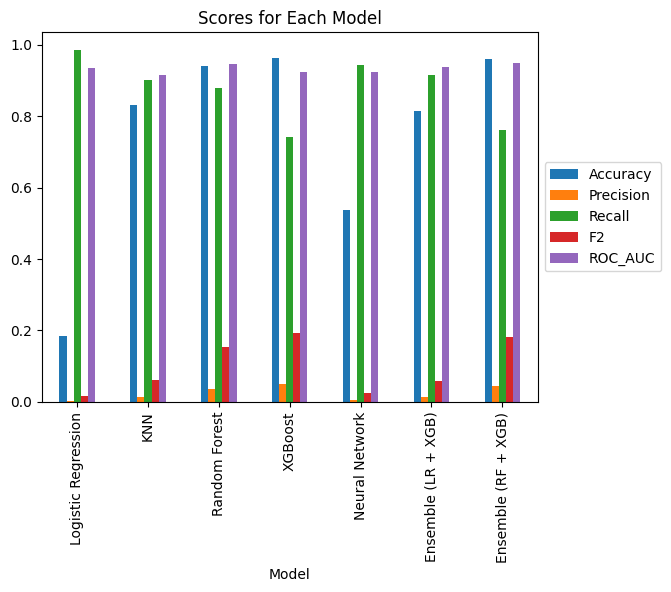

In [77]:
metrics_lib.plot(x='Model',
        kind='bar',
        stacked=False,
        title='Scores for Each Model')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()